# Сборный проект HR-аналитика

Компания «Работа с заботой» предоставила данные с характеристиками сотрудников отделу HR. Перед отделом стоит две задачи, которые можно решить методами машинного обучения. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. Вторая — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

## Цели проекта

<br>
1. Изучить данные
<br>
2. Разработать модели, решающие задачи компании.
<br>
3. Сформулировать общие выводы и дать рекомендации бизнесу

## План работы
<br>
1. Загрузить данные и ознакомиться с общей информацией
<br>
2. Выполнить предобработку
<br>
3. Провести исследовательский анализ данных
<br>
4. Провести корреляционный анализ данных
<br>
5. Обучить несколько моделей для каждой из задач, используя новую метрику
<br>
8. Описать работу моделей, сформулировать общие выводы и рекомендации для бизнеса

Устанавливаю и загружаю необходимые библиотеки для работы

In [3]:
!pip install phik -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 11.8 MB/s eta 0:00:00


In [4]:
!pip install shap -q

In [5]:
pip install plotly -q

In [6]:
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shap
import plotly.express as px

In [44]:
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score, recall_score, precision_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor, DummyClassifier

# Задача 1: предсказание уровня удовлетворённости сотрудника

## 1 Загрузка данных

### 1.1 Считываю csv файлы и создаю датайфремы

In [8]:
train_df = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
test_df = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
target_df = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

### 1.2 Вывожу основную информацию и первые строки каждого датафрейма

In [9]:
train_df.info()
train_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [10]:
test_df.info()
test_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [11]:
target_df.info()
target_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


**Вывод** Типы данных соответствуют фактическим данным. В датафреймах с входными данными присутствуют пропуски, которые будут убраны в дальнейшем в пайплайне. Данные соответстуют описанию

## 2 Предобработка данных

Делаю столбец id индексом во всех датафреймах, т.к. он не нужен для обучения и проверки модели, не является признаком

In [12]:
train_df = train_df.set_index('id')
test_df = test_df.set_index('id')
target_df = target_df.set_index('id')

Вывожу количество явных дубликатов в каждом датафрейме

In [13]:
print(train_df.duplicated().sum())
print(test_df.duplicated().sum())
print(target_df.duplicated().sum())

245
557
1902


Дубликаты из тестовой выборки будут убраны после разведочного анализа перед обучением модели, чтобы избежать переобучения. Т.к. сейчас это просто одинаковые данные разных работников компании

С помощью функции вывожу все уникальные значения в категориальных столбцах, чтобы обнаружить неявные дубликаты, опечатки или пустые значения

In [14]:
def dulbicates(data):
    for column in data:
        if data[column].dtype == 'object':
            print(column, data[column].unique())

In [15]:
dulbicates(train_df)

dept ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'high' 'low']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


In [16]:
dulbicates(test_df)

dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'low' 'high' ' ']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


Исправляю опечатку в уровне занимаемой должности в обоих датафреймах и заменяю пустые значения на NaN, чтобы далее проще было заменить пропуски в пайплайне

In [17]:
train_df['level'] = train_df['level'].str.replace('sinior', 'senior')
dulbicates(train_df)

dept ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level ['junior' 'middle' 'senior' nan]
workload ['medium' 'high' 'low']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


In [18]:
test_df['dept'] = test_df['dept'].replace(' ', np.nan, regex=True)
test_df['workload'] = test_df['workload'].replace(' ', np.nan, regex=True)
test_df['level'] = test_df['level'].str.replace('sinior', 'senior')
dulbicates(test_df)

dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
level ['junior' 'middle' 'senior' nan]
workload ['medium' 'low' 'high' nan]
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


**Вывод** В данных были обнаружены явные дубликаты, исправлены опечатки и пустые строки в датафреймах.

## 3 Исследовательский анализ данных

Объединяю тестовые данные для удобства их дальнейшего анализа

In [19]:
eda_test = pd.merge(test_df, target_df, left_index=True, right_index=True)

### 3.1 Статистический анализ данных

Вывожу статистику для тренировочного датасета, изучаю его, потому что обучение проходить будет именно на нем, а остальные данные будут использоваться для проверки работы модели

In [20]:
train_df.describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


In [21]:
eda_test.describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,2000.000000,2000.000000,2000.000000,2000.00000
mean,3.666500,3.526500,34066.800000,0.54878
std,2.537222,0.996892,15398.436729,0.22011
min,1.000000,1.000000,12000.000000,0.03000
25%,1.000000,3.000000,22800.000000,0.38000
50%,3.000000,4.000000,30000.000000,0.58000
75%,6.000000,4.000000,43200.000000,0.72000
max,10.000000,5.000000,96000.000000,1.00000


Из статистики видно, что в среднем сотрудники удовлетворены работой наполовину. Средняя зарпалата равна примерно 34 тысячам, а вот медианная уже на 3 тысячи меньше, это может быть связано с высокими зарплатами топ-менеджеров. В среднем сотрудники работают в компании около 3-4 лет. Средняя оценка сотрудников около 3.5 баллов, что кажется не очень хорошим показателем.

Различия между тестовыми и тренировочными данными незначительные, в целом они показывают одну и ту же картину

### 3.2 Построение и анализ графиков

Вывожу общие графики по всем числовым признакам в тренировочных данных

Text(784.3131313131312, 0.5, 'Удовлетворенность')

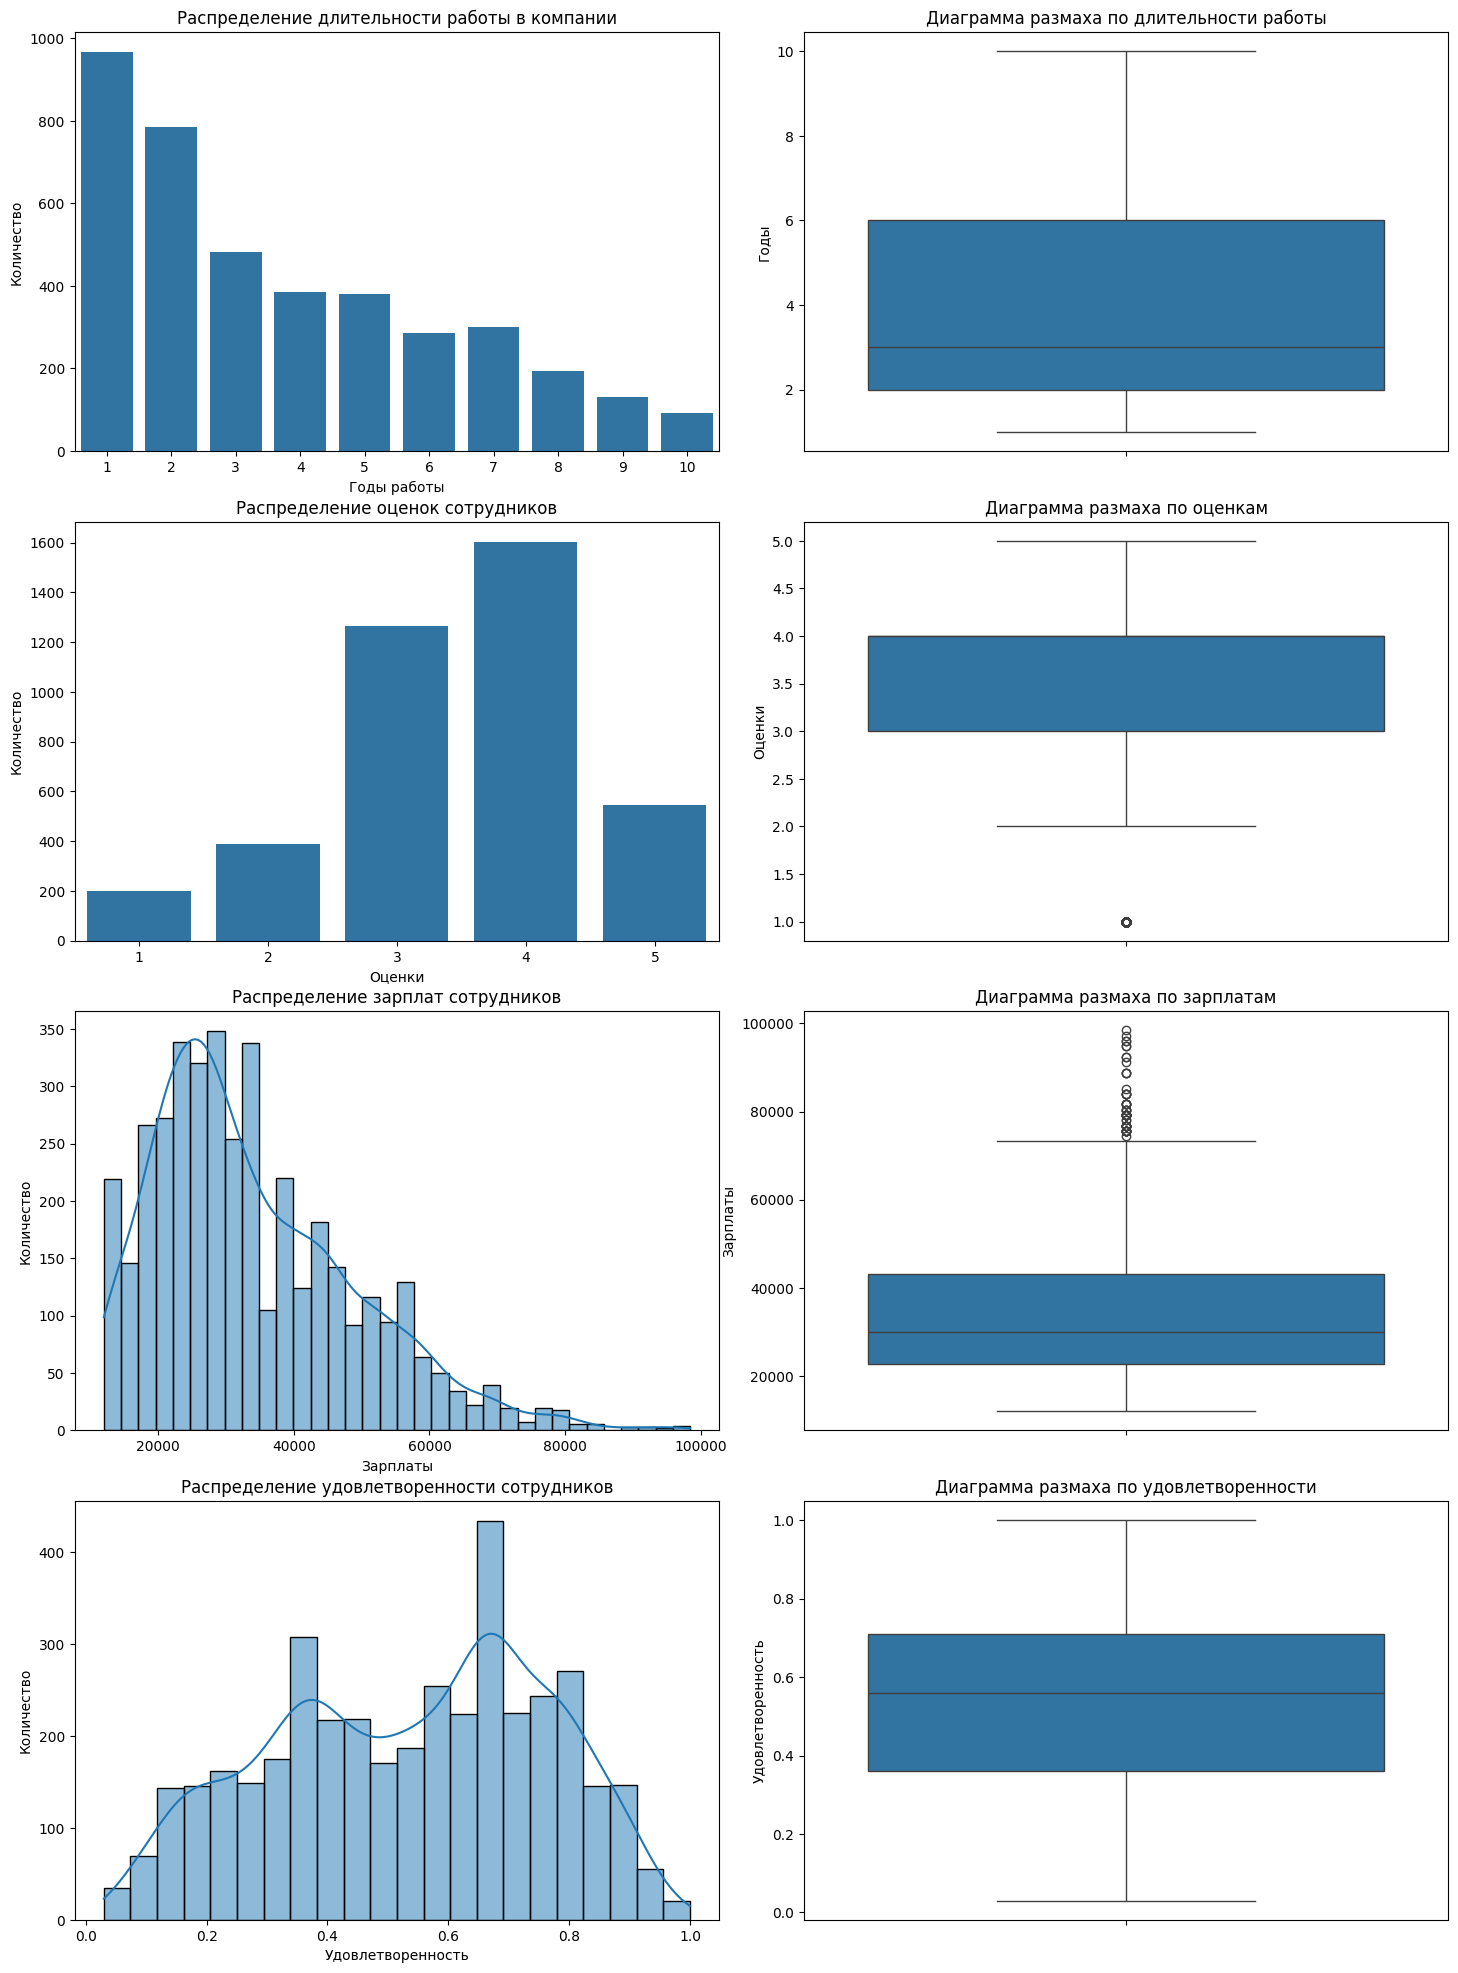

In [22]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))

plt.tight_layout(pad=3.0)

sns.countplot(data=train_df, x='employment_years', ax=axes[0, 0])
axes[0, 0].set_title('Распределение длительности работы в компании')
axes[0, 0].set_xlabel('Годы работы')
axes[0, 0].set_ylabel('Количество')
sns.boxplot(data=train_df, y='employment_years', ax=axes[0, 1])
axes[0, 1].set_title('Диаграмма размаха по длительности работы')
axes[0, 1].set_ylabel('Годы')
sns.countplot(data=train_df, x='supervisor_evaluation', ax=axes[1, 0])
axes[1, 0].set_title('Распределение оценок сотрудников')
axes[1, 0].set_xlabel('Оценки')
axes[1, 0].set_ylabel('Количество')
sns.boxplot(data=train_df, y='supervisor_evaluation', ax=axes[1, 1])
axes[1, 1].set_title('Диаграмма размаха по оценкам')
axes[1, 1].set_ylabel('Оценки')
sns.histplot(data=train_df, x='salary', kde=True, ax=axes[2, 0])
axes[2, 0].set_title('Распределение зарплат сотрудников')
axes[2, 0].set_xlabel('Зарплаты')
axes[2, 0].set_ylabel('Количество')
sns.boxplot(data=train_df, y='salary', ax=axes[2, 1])
axes[2, 1].set_title('Диаграмма размаха по зарплатам')
axes[2, 1].set_ylabel('Зарплаты')
sns.histplot(data=train_df, x='job_satisfaction_rate', kde=True, ax=axes[3, 0])
axes[3, 0].set_title('Распределение удовлетворенности сотрудников')
axes[3, 0].set_xlabel('Удовлетворенность')
axes[3, 0].set_ylabel('Количество')
sns.boxplot(data=train_df, y='job_satisfaction_rate', ax=axes[3, 1])
axes[3, 1].set_title('Диаграмма размаха по удовлетворенности')
axes[3, 1].set_ylabel('Удовлетворенность')

**Время работы в компании** По графикам видно, что большая часть людей работает в компании от 2 до 6 лет. Причем много людей, которые устроились недавно, т.е. 1-2 года стажа работы в компании. На диаграмме размаха видно, что отсутствуют выбросы и аномальные значения.
<br>
**Оценки сотрудников** Чаще всего начальство оценивает своих сотрудников в 3-4 балла, то что много сотрудников находится в районе 3 баллов на самом деле довольно тревожная тенденция. Это может говорить о каких либо проблемах в компании или конфликтах с руководством. На диаграмме размаха виден выброс в районе 1 балла, что логично, т.к. это низшая оценка работника, вряд ли большая доля сотрудников будет являться плохими работниками.
<br>
**Зарплаты сотрудников** Видно, что распределение зарплат смещено влево, в сторону меньших. Медианная зарплата около 30 тысяч. Это связано с тем, что большие зарплаты как правило и руководителей и самых ценных уважаемых сотрудников, а таких как правило всегда меньше, чем линейного персонала. На диаграмме размаха так же видно, что большие зарплаты скорее исключение, чем правило. Но эти данные лучше оставить, чтобы модель могла предсказывать поведение и таких людей тоже. Но в будущем лучше собрать больше данных, либо вынести их в отдельный кластер, для увеличения точности прогнозов.
<br>
**Удовлетворенность сотрудников** Удовлетворенность сотрудников распределена более менее равномерно, медианная около 0.5. Но видны небольшие пики около 0.4 и 0.7. На диаграмме размаха выбросов не видно.

Те же графики строю и для тестовой выборки

Text(784.3131313131312, 0.5, 'Удовлетворенность')

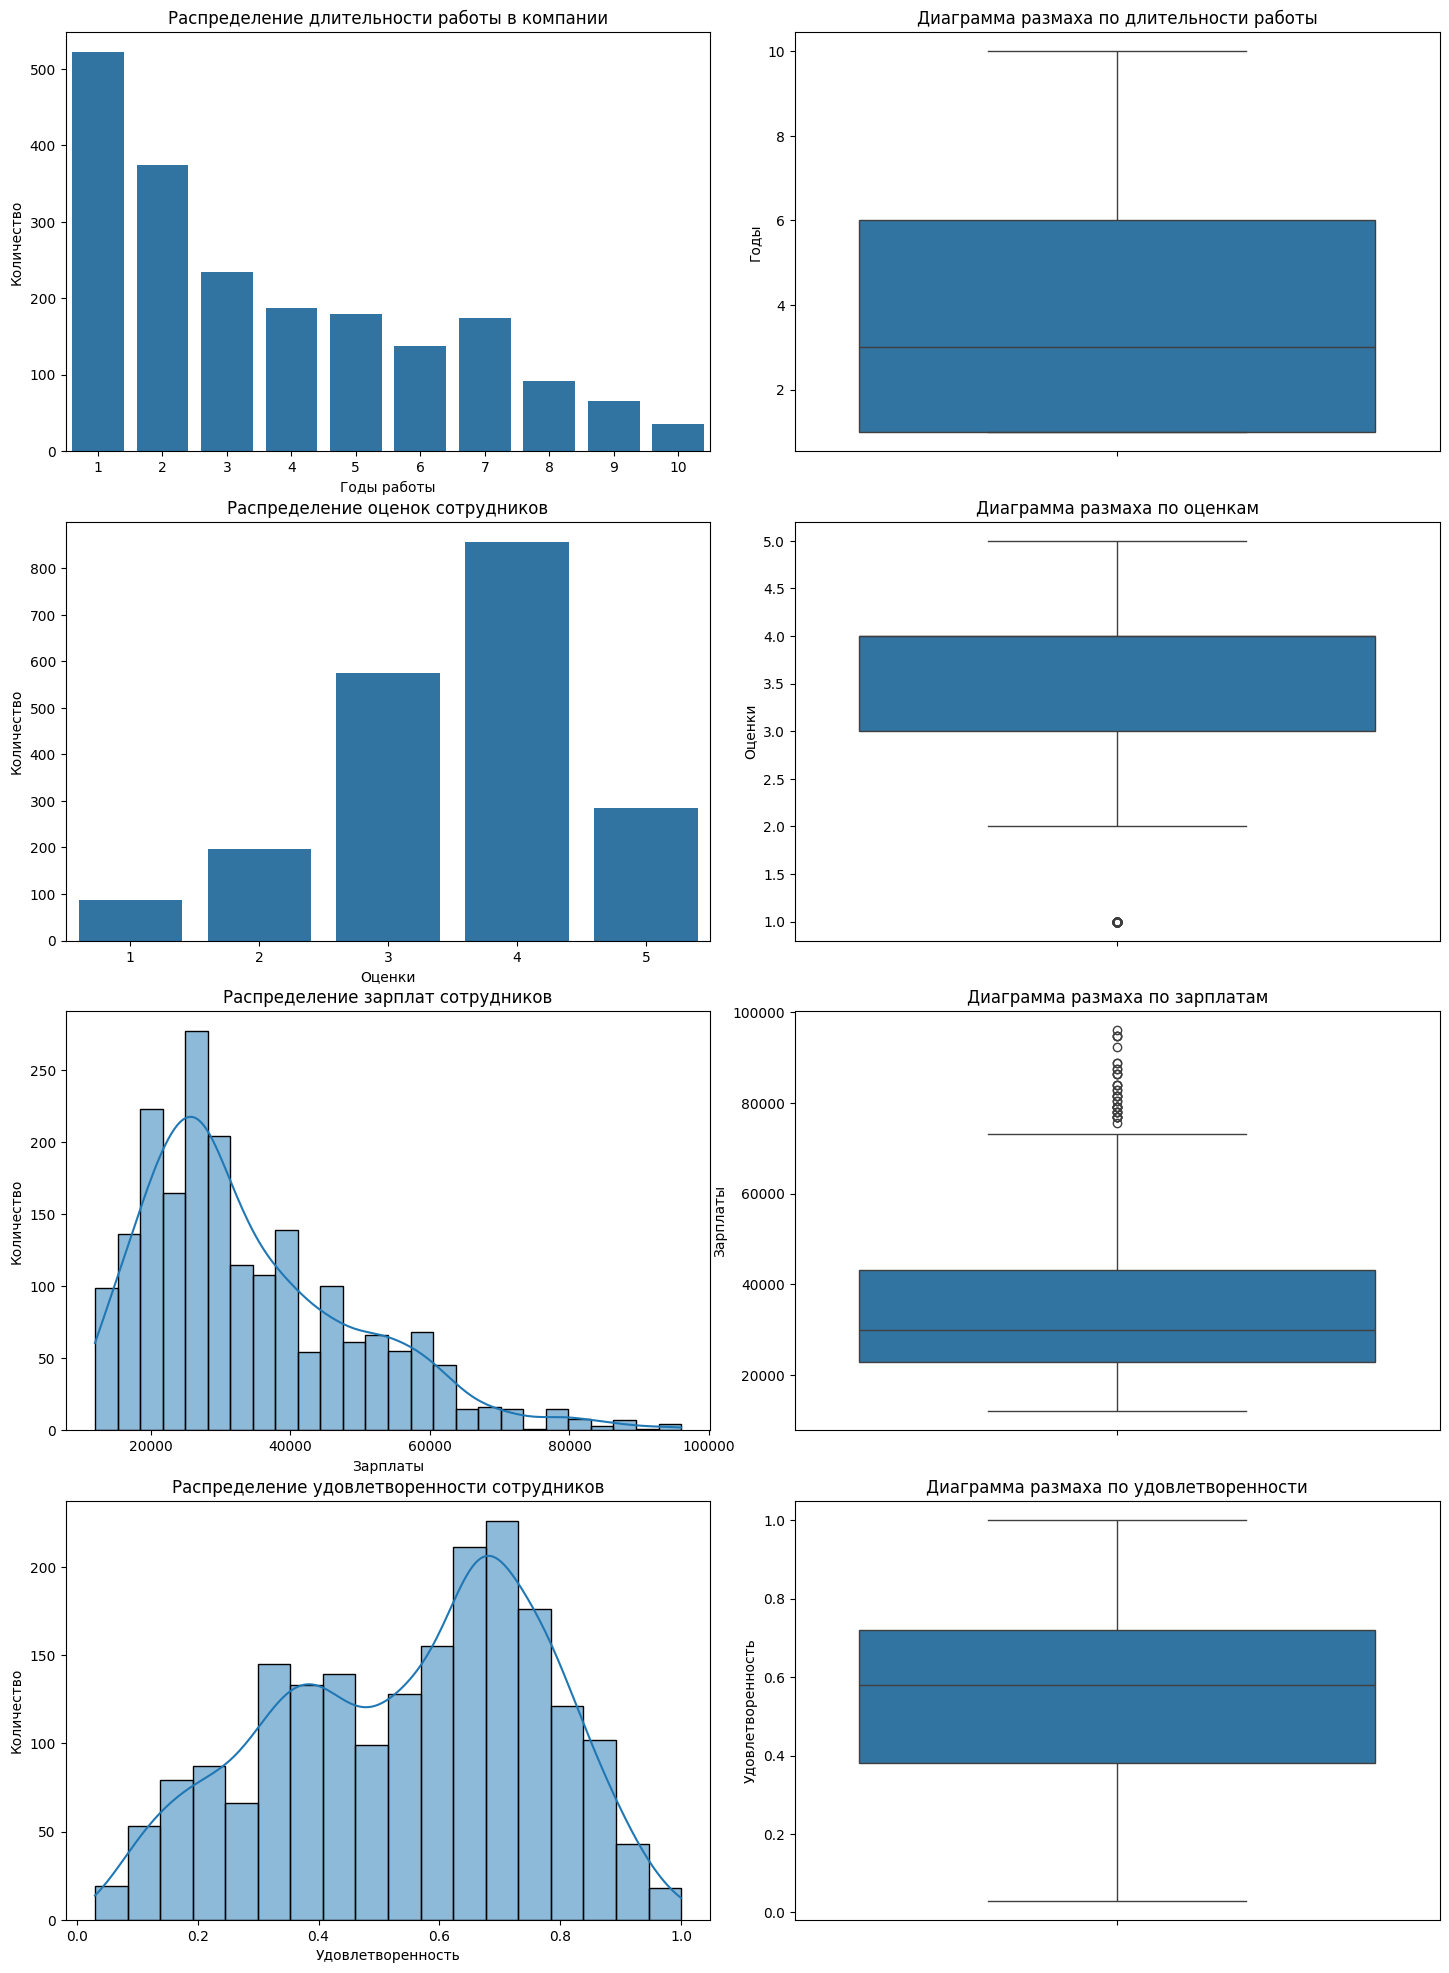

In [23]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))

plt.tight_layout(pad=3.0)

sns.countplot(data=eda_test, x='employment_years', ax=axes[0, 0])
axes[0, 0].set_title('Распределение длительности работы в компании')
axes[0, 0].set_xlabel('Годы работы')
axes[0, 0].set_ylabel('Количество')
sns.boxplot(data=eda_test, y='employment_years', ax=axes[0, 1])
axes[0, 1].set_title('Диаграмма размаха по длительности работы')
axes[0, 1].set_ylabel('Годы')
sns.countplot(data=eda_test, x='supervisor_evaluation', ax=axes[1, 0])
axes[1, 0].set_title('Распределение оценок сотрудников')
axes[1, 0].set_xlabel('Оценки')
axes[1, 0].set_ylabel('Количество')
sns.boxplot(data=eda_test, y='supervisor_evaluation', ax=axes[1, 1])
axes[1, 1].set_title('Диаграмма размаха по оценкам')
axes[1, 1].set_ylabel('Оценки')
sns.histplot(data=eda_test, x='salary', kde=True, ax=axes[2, 0])
axes[2, 0].set_title('Распределение зарплат сотрудников')
axes[2, 0].set_xlabel('Зарплаты')
axes[2, 0].set_ylabel('Количество')
sns.boxplot(data=eda_test, y='salary', ax=axes[2, 1])
axes[2, 1].set_title('Диаграмма размаха по зарплатам')
axes[2, 1].set_ylabel('Зарплаты')
sns.histplot(data=eda_test, x='job_satisfaction_rate', kde=True, ax=axes[3, 0])
axes[3, 0].set_title('Распределение удовлетворенности сотрудников')
axes[3, 0].set_xlabel('Удовлетворенность')
axes[3, 0].set_ylabel('Количество')
sns.boxplot(data=eda_test, y='job_satisfaction_rate', ax=axes[3, 1])
axes[3, 1].set_title('Диаграмма размаха по удовлетворенности')
axes[3, 1].set_ylabel('Удовлетворенность')

На тестовых данных видны те же распределения, что и на тренировочных.

Вывожу общие графики по категориальным признакам тренировочных данных

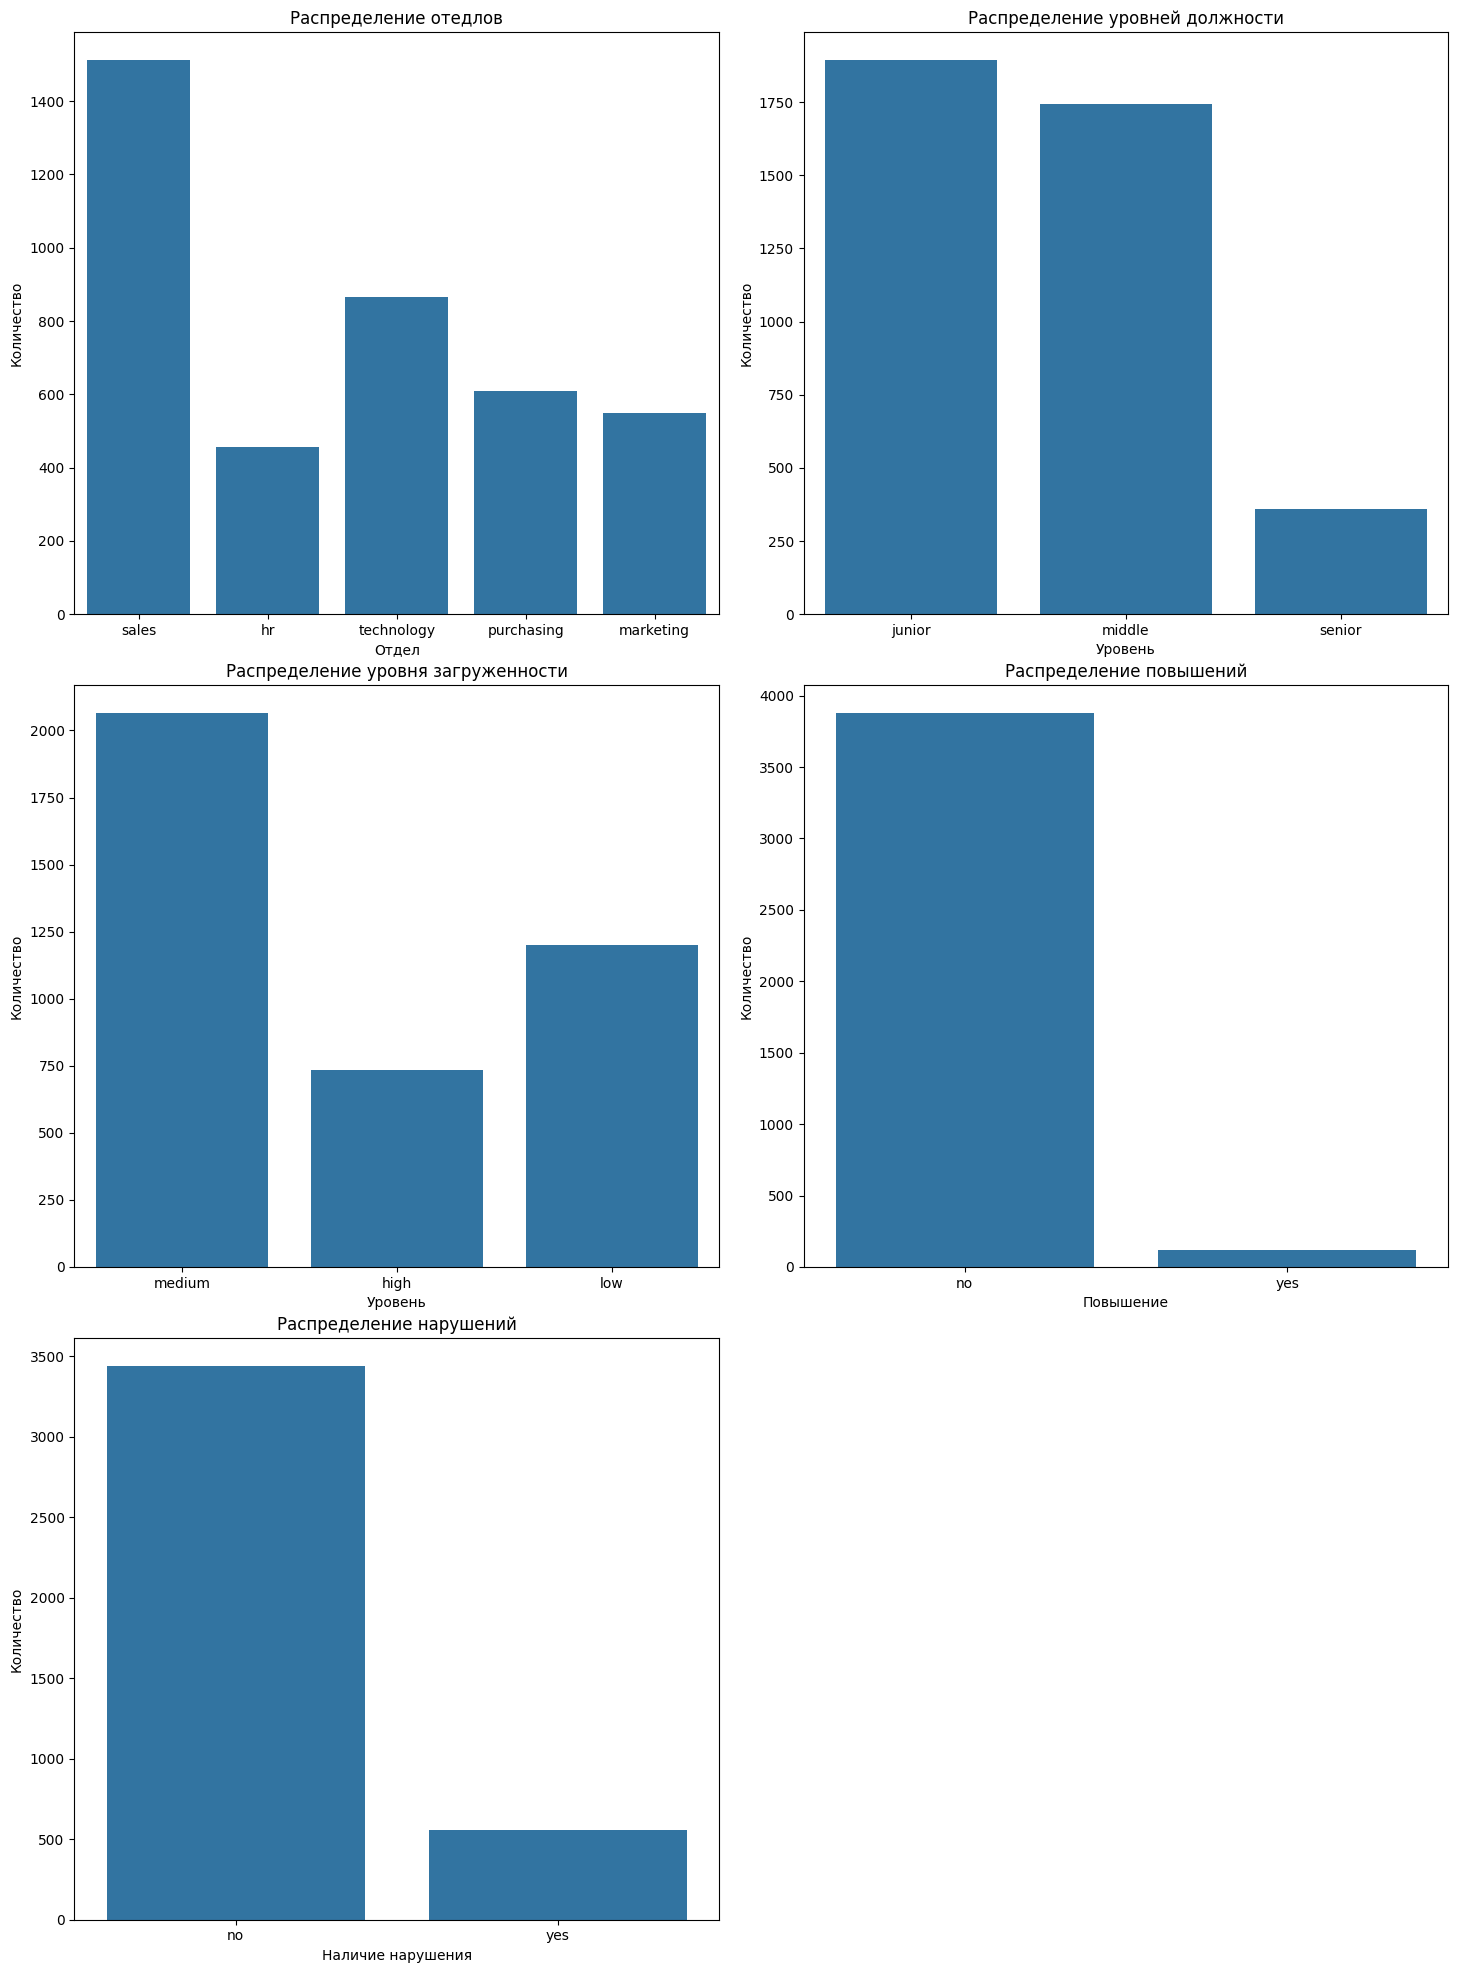

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 20))

plt.tight_layout(pad=3.0)

axes[2, 1].axis('off')

sns.countplot(data=train_df, x='dept', ax=axes[0, 0])
axes[0, 0].set_title('Распределение отедлов')
axes[0, 0].set_xlabel('Отдел')
axes[0, 0].set_ylabel('Количество')
sns.countplot(data=train_df, x='level', ax=axes[0, 1])
axes[0, 1].set_title('Распределение уровней должности')
axes[0, 1].set_xlabel('Уровень')
axes[0, 1].set_ylabel('Количество')
sns.countplot(data=train_df, x='workload', ax=axes[1, 0])
axes[1, 0].set_title('Распределение уровня загруженности')
axes[1, 0].set_xlabel('Уровень')
axes[1, 0].set_ylabel('Количество')
sns.countplot(data=train_df, x='last_year_promo', ax=axes[1, 1])
axes[1, 1].set_title('Распределение повышений')
axes[1, 1].set_xlabel('Повышение')
axes[1, 1].set_ylabel('Количество')
sns.countplot(data=train_df, x='last_year_violations', ax=axes[2, 0])
axes[2, 0].set_title('Распределение нарушений')
axes[2, 0].set_xlabel('Наличие нарушения')
axes[2, 0].set_ylabel('Количество');

**Отделы** Большая часть сотрудников работает в отделе продаж и в отделе технологий.
<br>
**Должности** Junior и middle-специалистов гораздо больше, чем senior, что логично сочетается с распределением зарплат сотрудников.
<br>
**Загруженность** У большей части сотрудников средняя загруженность, у меньшей части высокая.
<br>
**Повышения** На графике видно, что повышение происходит довольно редко. За год почти все сотрудники остались на прежних позициях.
<br>
**Нарушения** Людей с нарушениями гораздо меньше, что хорошо для компании.

Те же графики строю для тестовой выборки

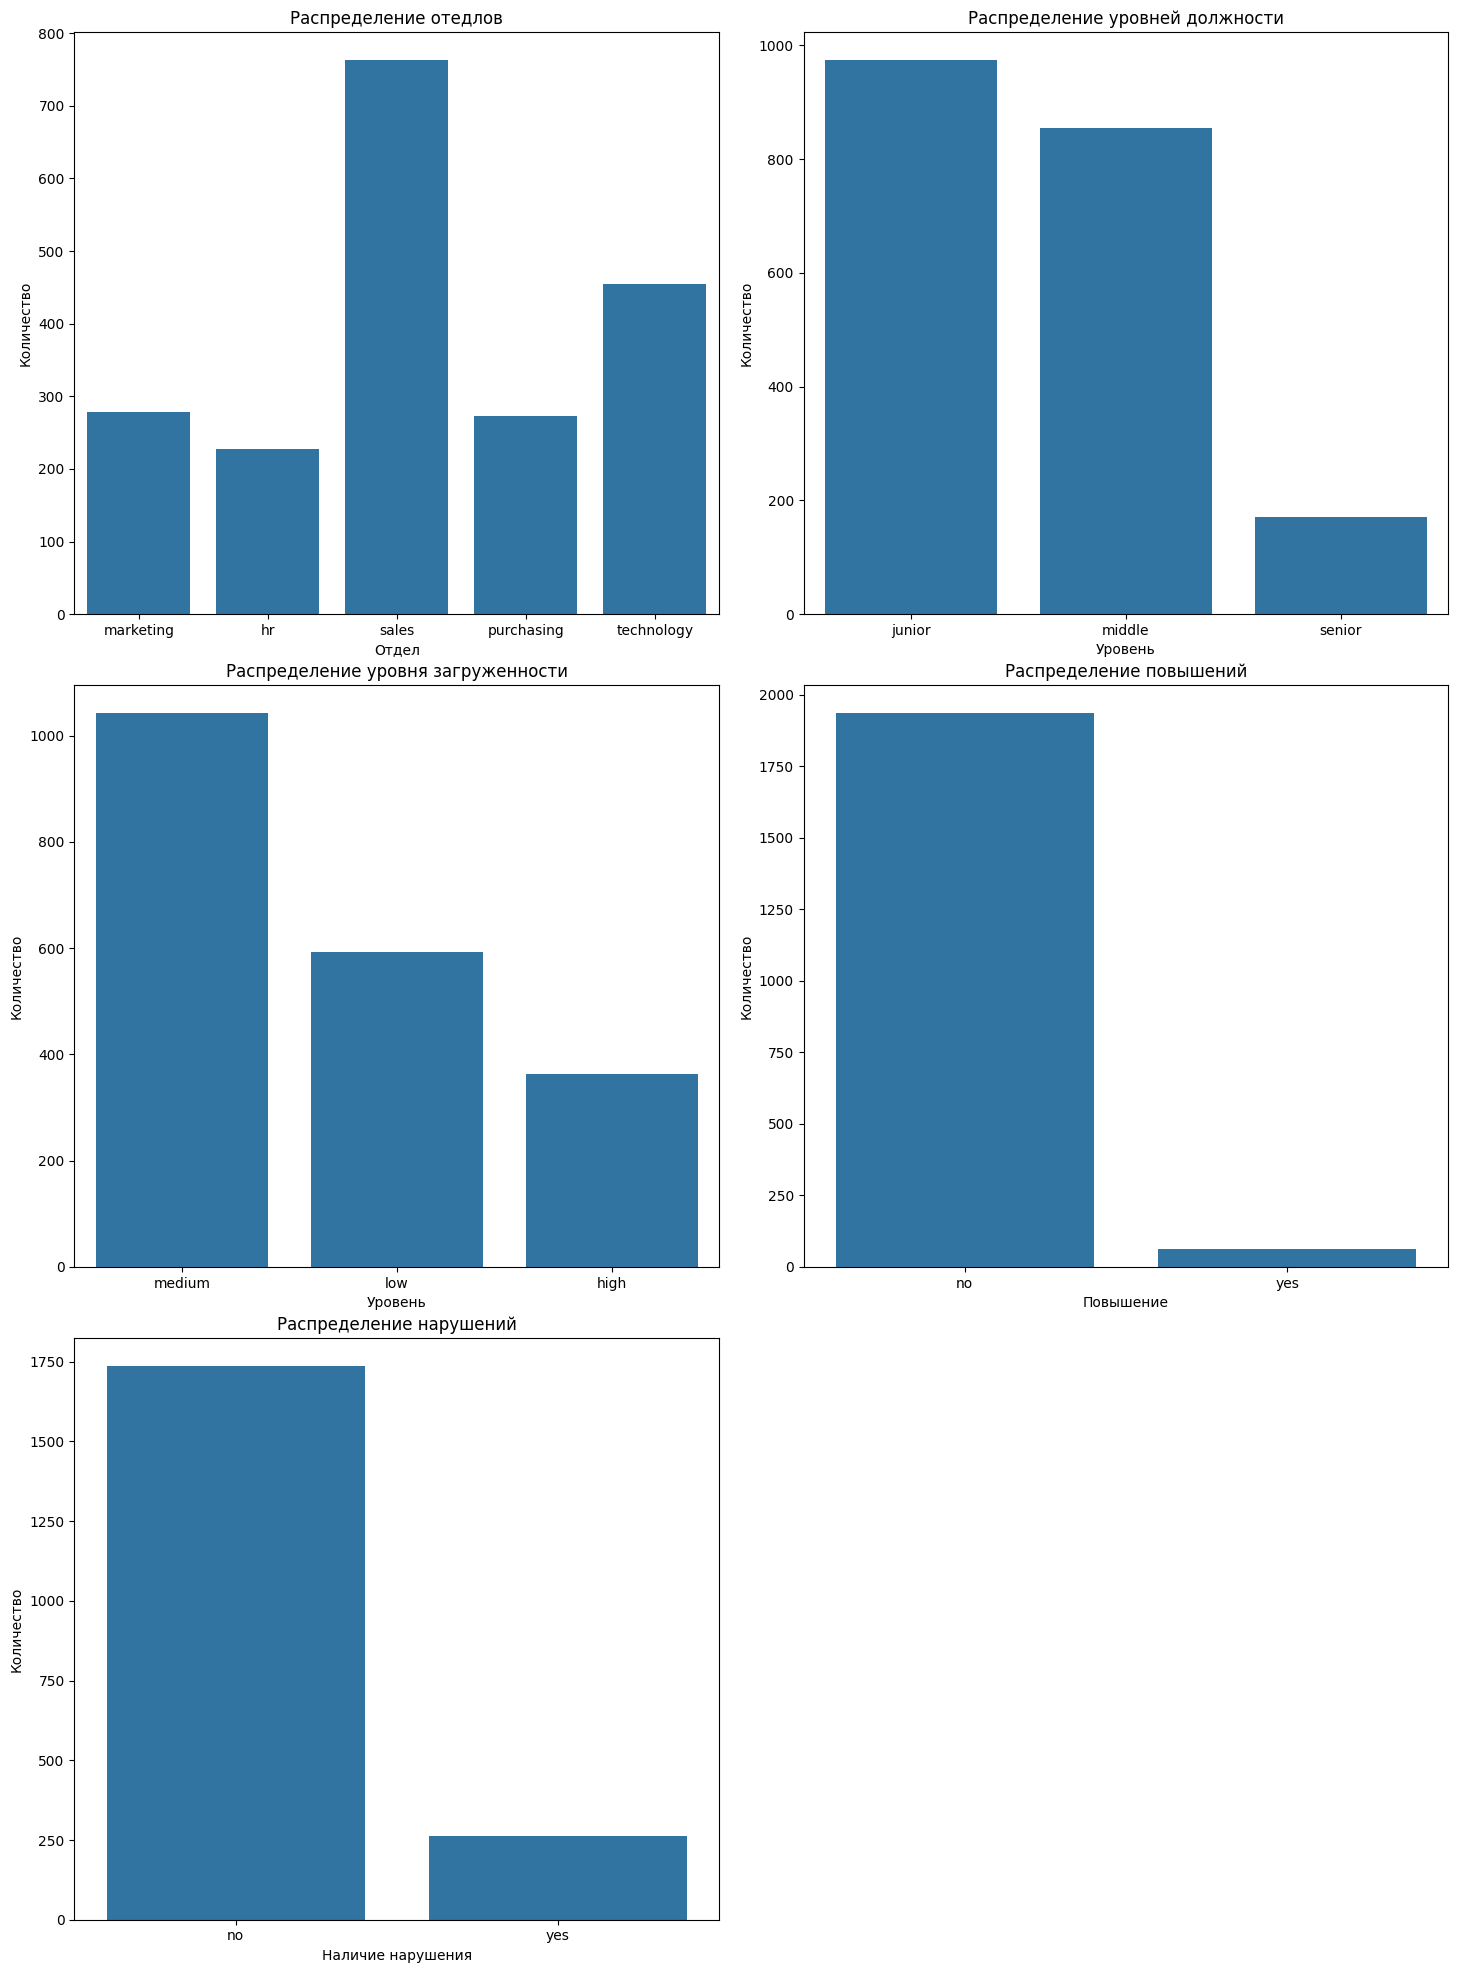

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 20))

plt.tight_layout(pad=3.0)

axes[2, 1].axis('off')

sns.countplot(data=eda_test, x='dept', ax=axes[0, 0])
axes[0, 0].set_title('Распределение отедлов')
axes[0, 0].set_xlabel('Отдел')
axes[0, 0].set_ylabel('Количество')
sns.countplot(data=eda_test, x='level', ax=axes[0, 1])
axes[0, 1].set_title('Распределение уровней должности')
axes[0, 1].set_xlabel('Уровень')
axes[0, 1].set_ylabel('Количество')
sns.countplot(data=eda_test, x='workload', ax=axes[1, 0])
axes[1, 0].set_title('Распределение уровня загруженности')
axes[1, 0].set_xlabel('Уровень')
axes[1, 0].set_ylabel('Количество')
sns.countplot(data=eda_test, x='last_year_promo', ax=axes[1, 1])
axes[1, 1].set_title('Распределение повышений')
axes[1, 1].set_xlabel('Повышение')
axes[1, 1].set_ylabel('Количество')
sns.countplot(data=eda_test, x='last_year_violations', ax=axes[2, 0])
axes[2, 0].set_title('Распределение нарушений')
axes[2, 0].set_xlabel('Наличие нарушения')
axes[2, 0].set_ylabel('Количество');

Данные в тестовой и тренировочной выборках схожи по распределению, что облегчит работу модели

### 3.3 Кореляционный анализ

Строю матрицу корреляций для признаков из тренировочного датасета

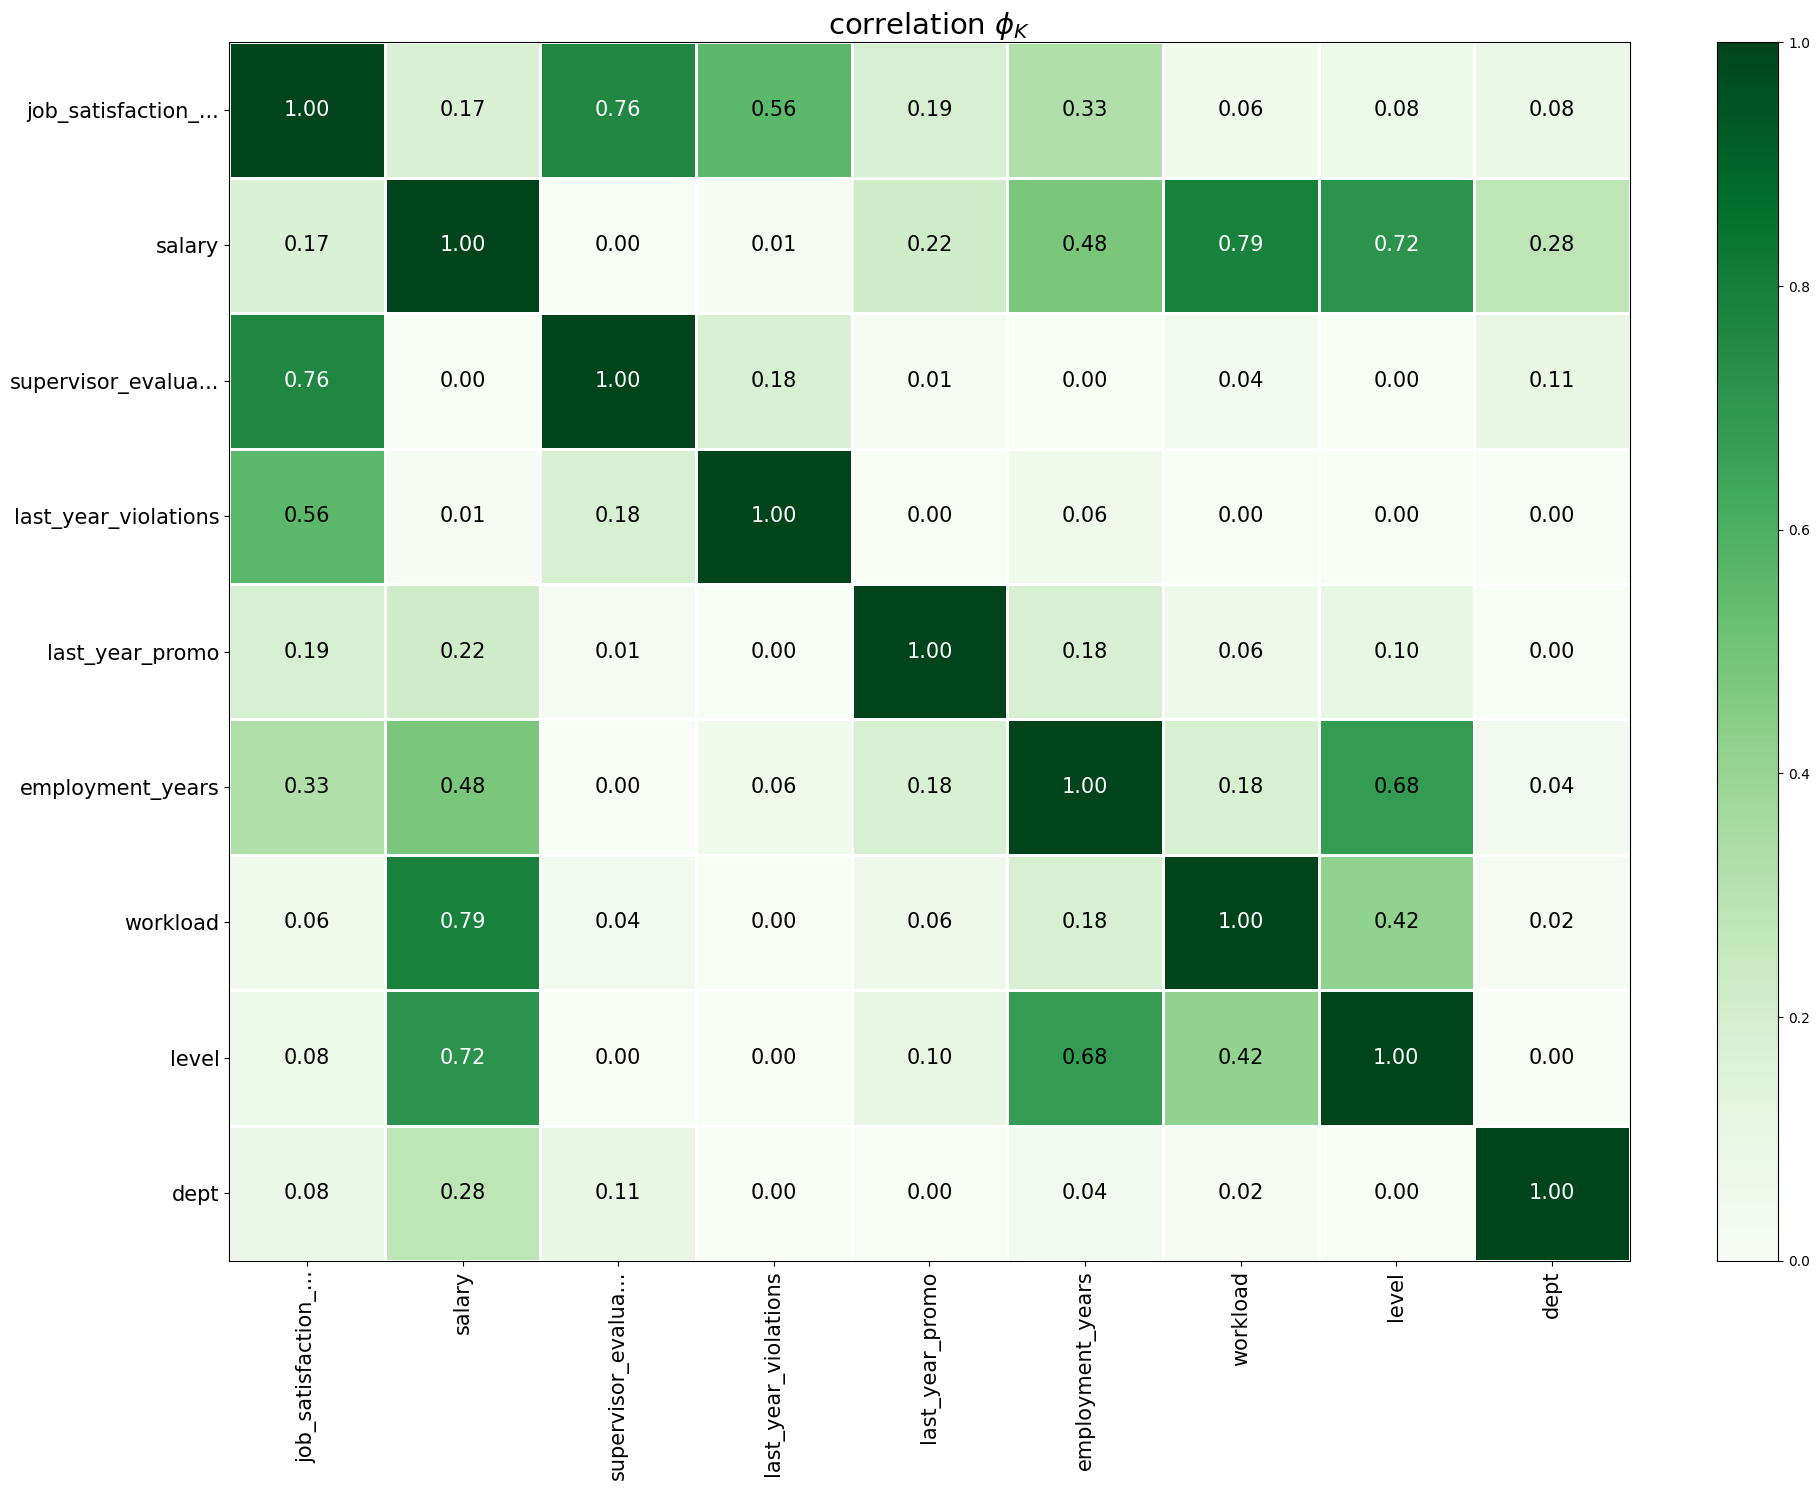

In [26]:
interval_cols = ['salary', 'job_satisfaction_rate']

phik_overview = phik_matrix(train_df, interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

У целевого признака - удовлетворенность работой - наблюдается высокая корреляция с оценкой руководителя и повышением за последний год. Мультиколлинеарности в признаках не обнаружено. Также видно, что зарплата коррелирует с уровнем загруженности и уровнем занимаемой должности.

Строю матрицу корреляций для тестовой выборки

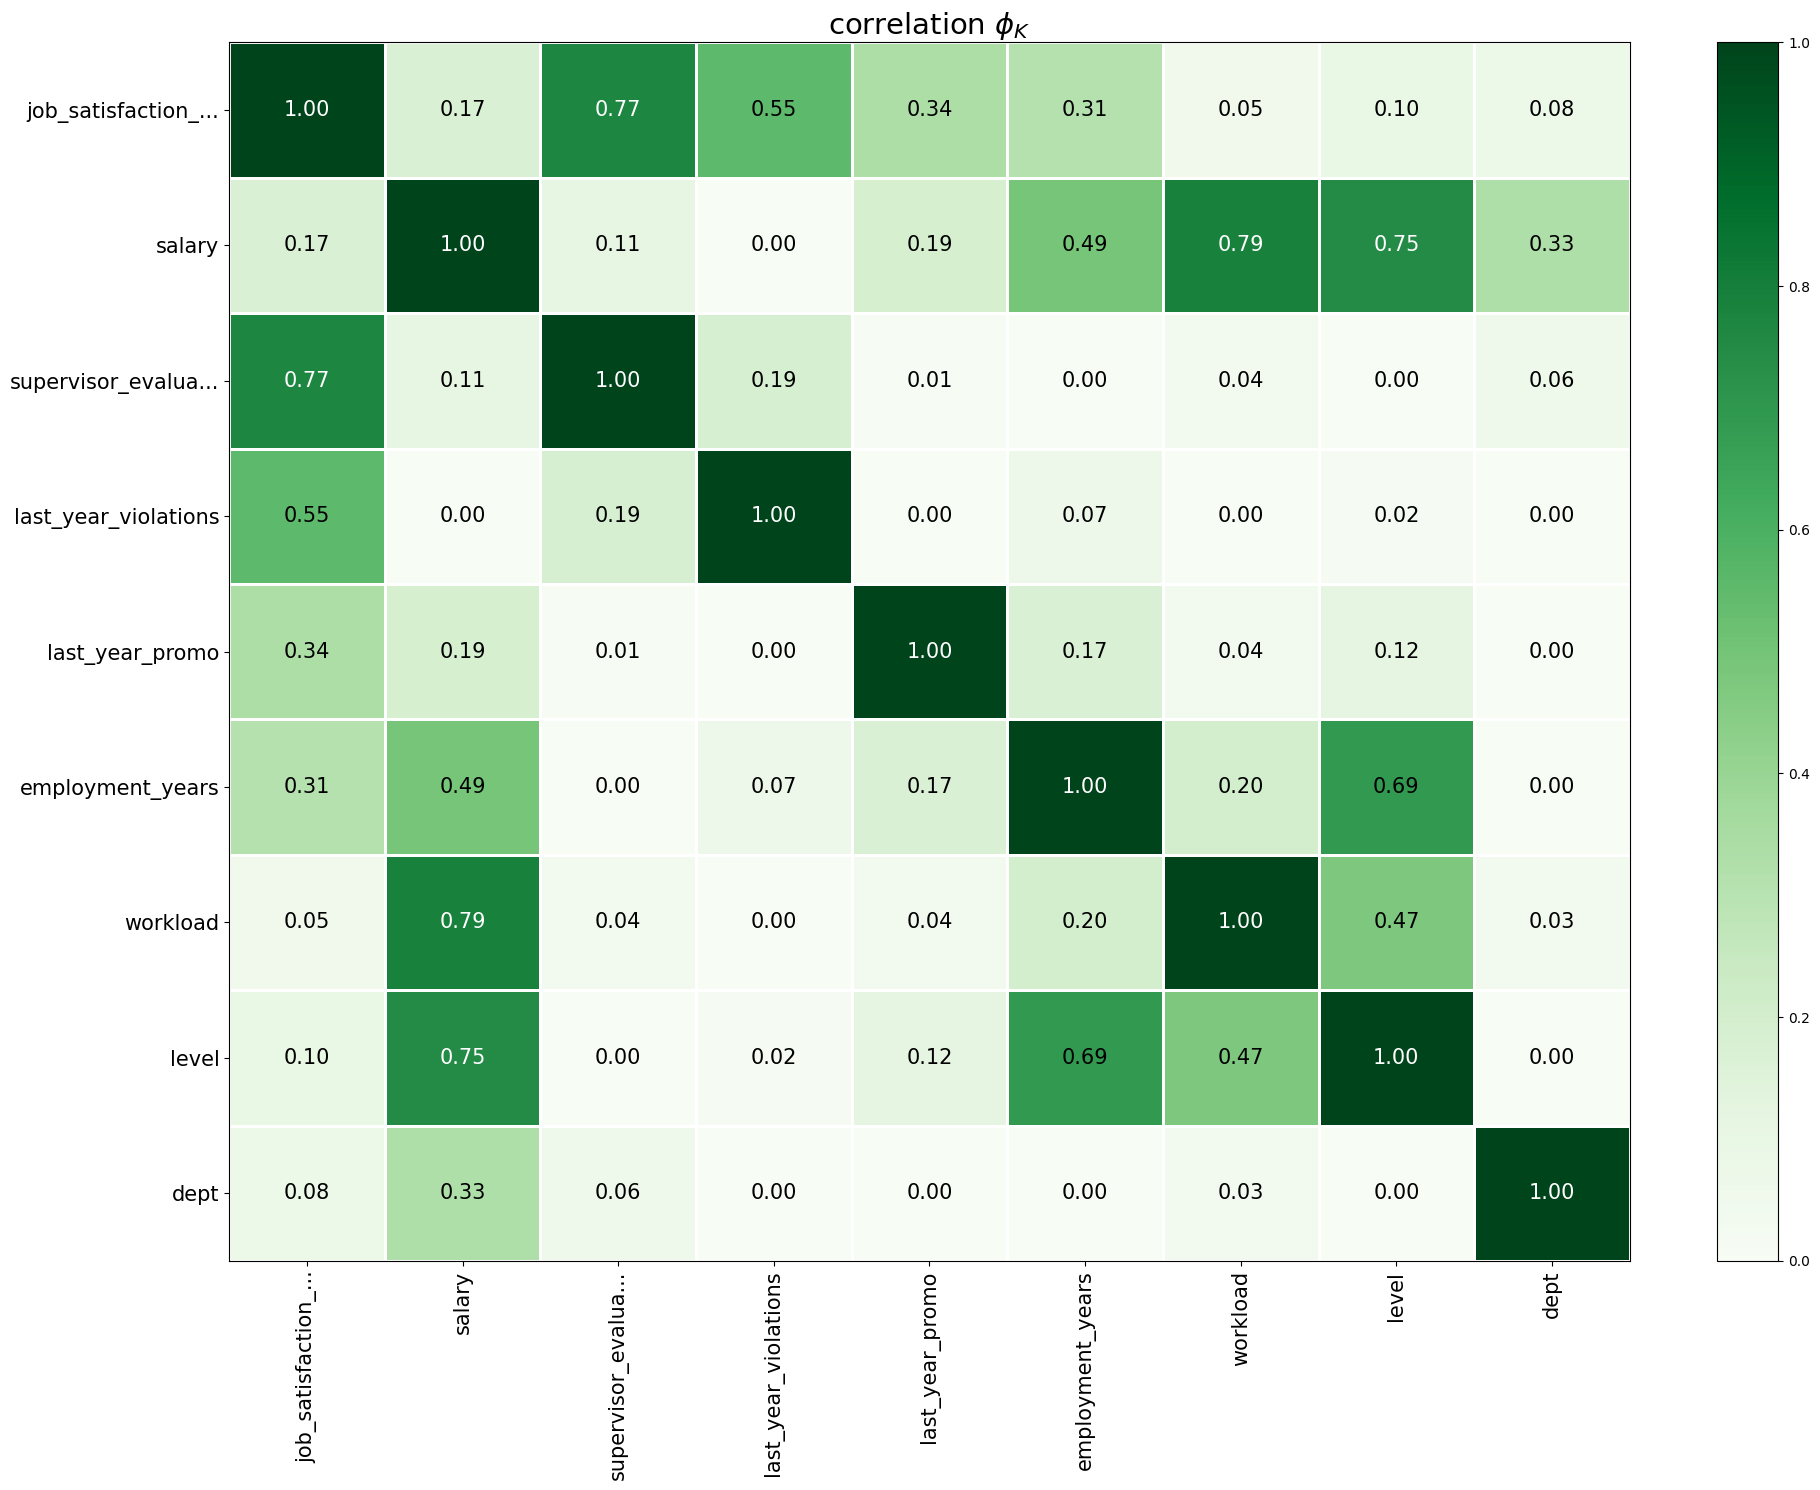

In [27]:
interval_cols = ['salary', 'job_satisfaction_rate']

phik_overview = phik_matrix(eda_test, interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

**Вывод** Данные в обеих выборках имеют одинаковую структуру и очень схожие распределения, это значит, что оценка модели будет корректной, т.к. нет существенных различий.

## 4 Подготовка данных

Выполняю подготовку данных для обучения моделей

Убираю дубликаты из тренировочной выборки, чтобы избежать переобучения

In [28]:
train_df = train_df.drop_duplicates()
print(train_df.duplicated().sum())

0


Объединяю тестовые данные по индексу(Id), чтобы сравнивать предсказания с реальными значениями для одного и того же работника

In [29]:
test_data = pd.merge(test_df, target_df, left_index=True, right_index=True)
test_data.head(5)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79
686555,hr,junior,medium,1,no,no,4,30000,0.72
467458,sales,middle,low,5,no,no,4,19200,0.64
418655,sales,middle,low,6,no,no,4,19200,0.60
789145,hr,middle,medium,5,no,no,5,40800,0.75


In [30]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train = train_df.drop('job_satisfaction_rate', axis=1)
y_train = train_df['job_satisfaction_rate']

X_test = test_data.drop('job_satisfaction_rate', axis=1)
y_test = test_data['job_satisfaction_rate']

ohe_columns = ['dept', 'last_year_promo', 'last_year_violations', 'level']
ord_columns = ['workload']
num_columns = ['employment_years', 'salary', 'supervisor_evaluation']

Создаю пайплайн, который содержит две модели для задач линейной регресии

In [31]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
         ('ord',  OrdinalEncoder(
                categories=[
                    ['medium', 'high', 'low'],
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [32]:
data_preprocessor = ColumnTransformer(
    [
     ('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', RobustScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [33]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

## 5 Обучение моделей

### 5.1 Поиск лучшей модели

Создаю словарь с гиперпараметрами для моделей

In [34]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [3, 5, 7],
        'models__min_samples_split': [10, 20],
        'models__min_samples_leaf': [2, 5],
        'models__max_features': [0.3, 0.5, 'sqrt'],
        'models__max_leaf_nodes': [20, 50],
        'preprocessor__num': ['passthrough']
    },

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },

    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200],
        'models__max_depth': [None, 5, 10],
        'models__min_samples_split': [10, 20],
        'models__min_samples_leaf': [2, 5],
        'models__max_features': ['sqrt', 0.5],
        'models__bootstrap': [True],
        'models__max_samples': [0.7, 0.8],
        'preprocessor__num': ['passthrough']
    }
]

Прописываю функцию, при помощи которой будет считаться метрика SMAPE

In [35]:
def smape(y_true, y_pred):
    y_true = np.asarray(y_true).flatten()
    y_pred = np.asarray(y_pred).flatten()
    numerator = 2 * np.abs(y_pred - y_true)
    denominator = np.abs(y_true) + np.abs(y_pred) + 1e-8
    return 100 * np.mean(numerator / denominator)

Создаю кастомную метрику

In [36]:
smape_scorer = make_scorer(
    smape,
    greater_is_better=False
)

Начинаю обучение и подбор лучшей модели

In [37]:
random_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring=smape_scorer,
    n_jobs=-1,
    verbose=1,
    n_iter=100,
    random_state=RANDOM_STATE
)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_ye...
                                         'models__bootstrap': [True],
                                         'models__max_depth': [None, 5, 10],
                                         'models__max_features': ['sqrt', 0.5],
                                         'models__max_samples': [0.7, 0.8],
                                         'models__min_samples_leaf': [2, 5],
                                         'models__min_samples_split': [10, 20],
                                         'models__n_estimators': [100, 200],
                                         'preprocessor__num': ['passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'),
                   verbose=1)

In [38]:
print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', -random_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations',
                                                   'level']),
                         

In [39]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f'Метрика SMAPE на тестовой выборке: {smape(y_test, y_pred)}')

Метрика SMAPE на тестовой выборке: 13.227376776906812


Метрика SMAPE на тестовой выборке получилась 13.22, что является вполне неплохим результатом

### 5.2 Проверка адекватности модели

In [47]:
dummy_regr = DummyRegressor(strategy='mean')
dummy_regr.fit(X_train, y_train)
pred = dummy_regr.predict(X_test)
print('Метрика фиктивной модели:', smape(y_test, pred))

Метрика фиктивной модели: 38.26225748212344


Метрика DummyRegressor вышла хуже, что подтверждает эффективность выбранной модели

### 5.3 Анализ важности признаков

Далее строю график для анализа важности признаков

In [40]:
best_pipeline = random_search.best_estimator_
best_model = best_pipeline.named_steps['models']

In [41]:
preprocessor = best_pipeline.named_steps['preprocessor']

X_processed = preprocessor.transform(X_train)

In [42]:
explainer = shap.TreeExplainer(
    model=best_model
)
shap_values = explainer.shap_values(X_processed)

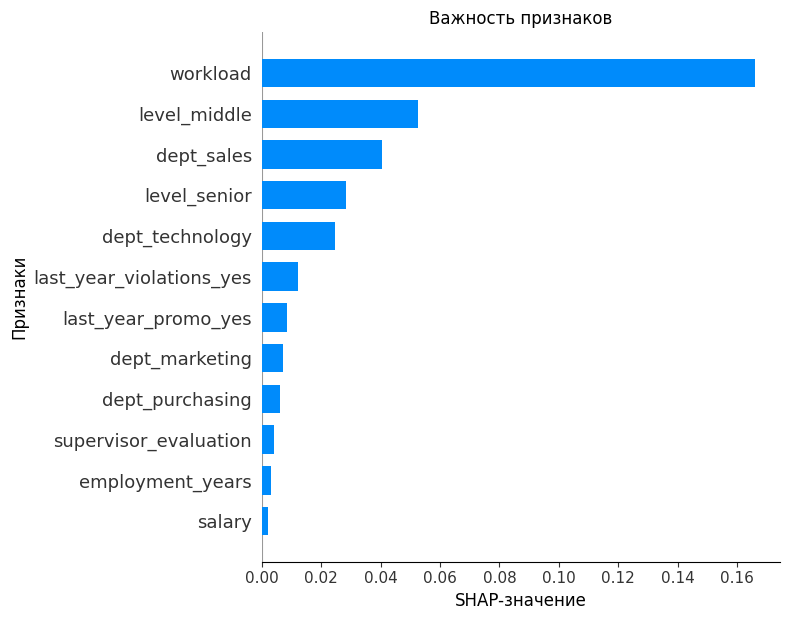

In [43]:
num_features = preprocessor.transformers_[2][2]
ohe_features = preprocessor.named_transformers_['ohe'].get_feature_names_out(ohe_columns)
ord_features = preprocessor.named_transformers_['ord'].get_feature_names_out(ord_columns)

feature_names = num_features + ohe_features.tolist() + ord_features.tolist()

shap.summary_plot(
    shap_values,
    X_processed,
    feature_names=feature_names,
    plot_type="bar",
    show=False
)

ax = plt.gca()
ax.set_title("Важность признаков", fontsize=12)
ax.set_ylabel("Признаки", fontsize=12)
ax.set_xlabel("SHAP-значение", fontsize=12)

plt.tight_layout()
plt.show()

По графику видно, что сильнее всего на модель влияют данные о людях из отдела продаж и отдела технологий. Так же влияе зарплата и оценка руководителя. Загруженность персонала почти не влияет на итоговые значения.

## 6 Выводы по 1 задаче

Модель дерева решений справилась лучше простой модели линейной регрессии по нескольким причинам. Ей не нужно масштабирование данных, она захватывает нелинейные связи. Также дерево решений менее чувствительно к выбросам в данных, а исходя из исследовательского анализа, они там присутствуют.

# Задача 2: предсказание увольнения сотрудника из компании

## 1 Загрузка данных

### 1.1 Считываю csv файлы и создаю датайфремы

Так как тестовая выборка остается та же, загружаю только тренировочную и таргет

In [48]:
train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
traget_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

### 1.2 Вывожу основную информацию и первые строки каждого датафрейма

In [49]:
train_quit.info()
train_quit.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [50]:
traget_quit.info()
traget_quit.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


**Вывод** Пропусков в данных не обнаружено, данные соответствуют описанию

## 2 Предобработка данных

Делаю столбец id индексом во всех датафреймах, т.к. он не нужен для обучения и проверки модели, не является признаком

In [51]:
train_quit = train_quit.set_index('id')
target_quit = traget_quit.set_index('id')

Вывожу количество явных дубликатов в каждом датафрейме

In [52]:
print(train_quit.duplicated().sum())
print(target_quit.duplicated().sum())

1413
1998


С помощью функции вывожу все уникальные значения в категориальных столбцах, чтобы обнаружить неявные дубликаты, опечатки или пустые значения

In [53]:
dulbicates(train_quit)

dept ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level ['middle' 'junior' 'sinior']
workload ['high' 'medium' 'low']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']
quit ['no' 'yes']


Исправляю опечатку в уровне занимаемой должности

In [54]:
train_quit['level'] = train_quit['level'].str.replace('sinior', 'senior')
dulbicates(train_quit)

dept ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level ['middle' 'junior' 'senior']
workload ['high' 'medium' 'low']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']
quit ['no' 'yes']


**Вывод** В данных были обнаружены явные дубликаты, исправлены опечатки в датафреймах.

## 3 Исследовательский анализ данных

Объединяю тестовую выборку с целевым признаком для eda анализа

In [55]:
eda_second = pd.merge(test_df, target_quit, right_index=True, left_index=True)
eda_second.head(5)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,no
686555,hr,junior,medium,1,no,no,4,30000,no
467458,sales,middle,low,5,no,no,4,19200,no
418655,sales,middle,low,6,no,no,4,19200,no
789145,hr,middle,medium,5,no,no,5,40800,no


### 3.1 Статистический анализ данных

In [56]:
train_quit.describe()

,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000
mean,3.701500,3.474750,33805.800000
std,2.541852,1.004049,15152.415163
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


Из статистики видно, что средний и медианный стаж работы в компании равен 4 годам. Средняя оценка руководителя - 3 балла. Средняя зарплата 33 тысячи, а медианная 30 тысяч, что скорее всего связано с выбросами в виде высоких зарплат

In [57]:
eda_second.describe()

,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


### 3.2 Построение и анализ графиков

Строю графики числовых признаков с учетом отношения к увольнению

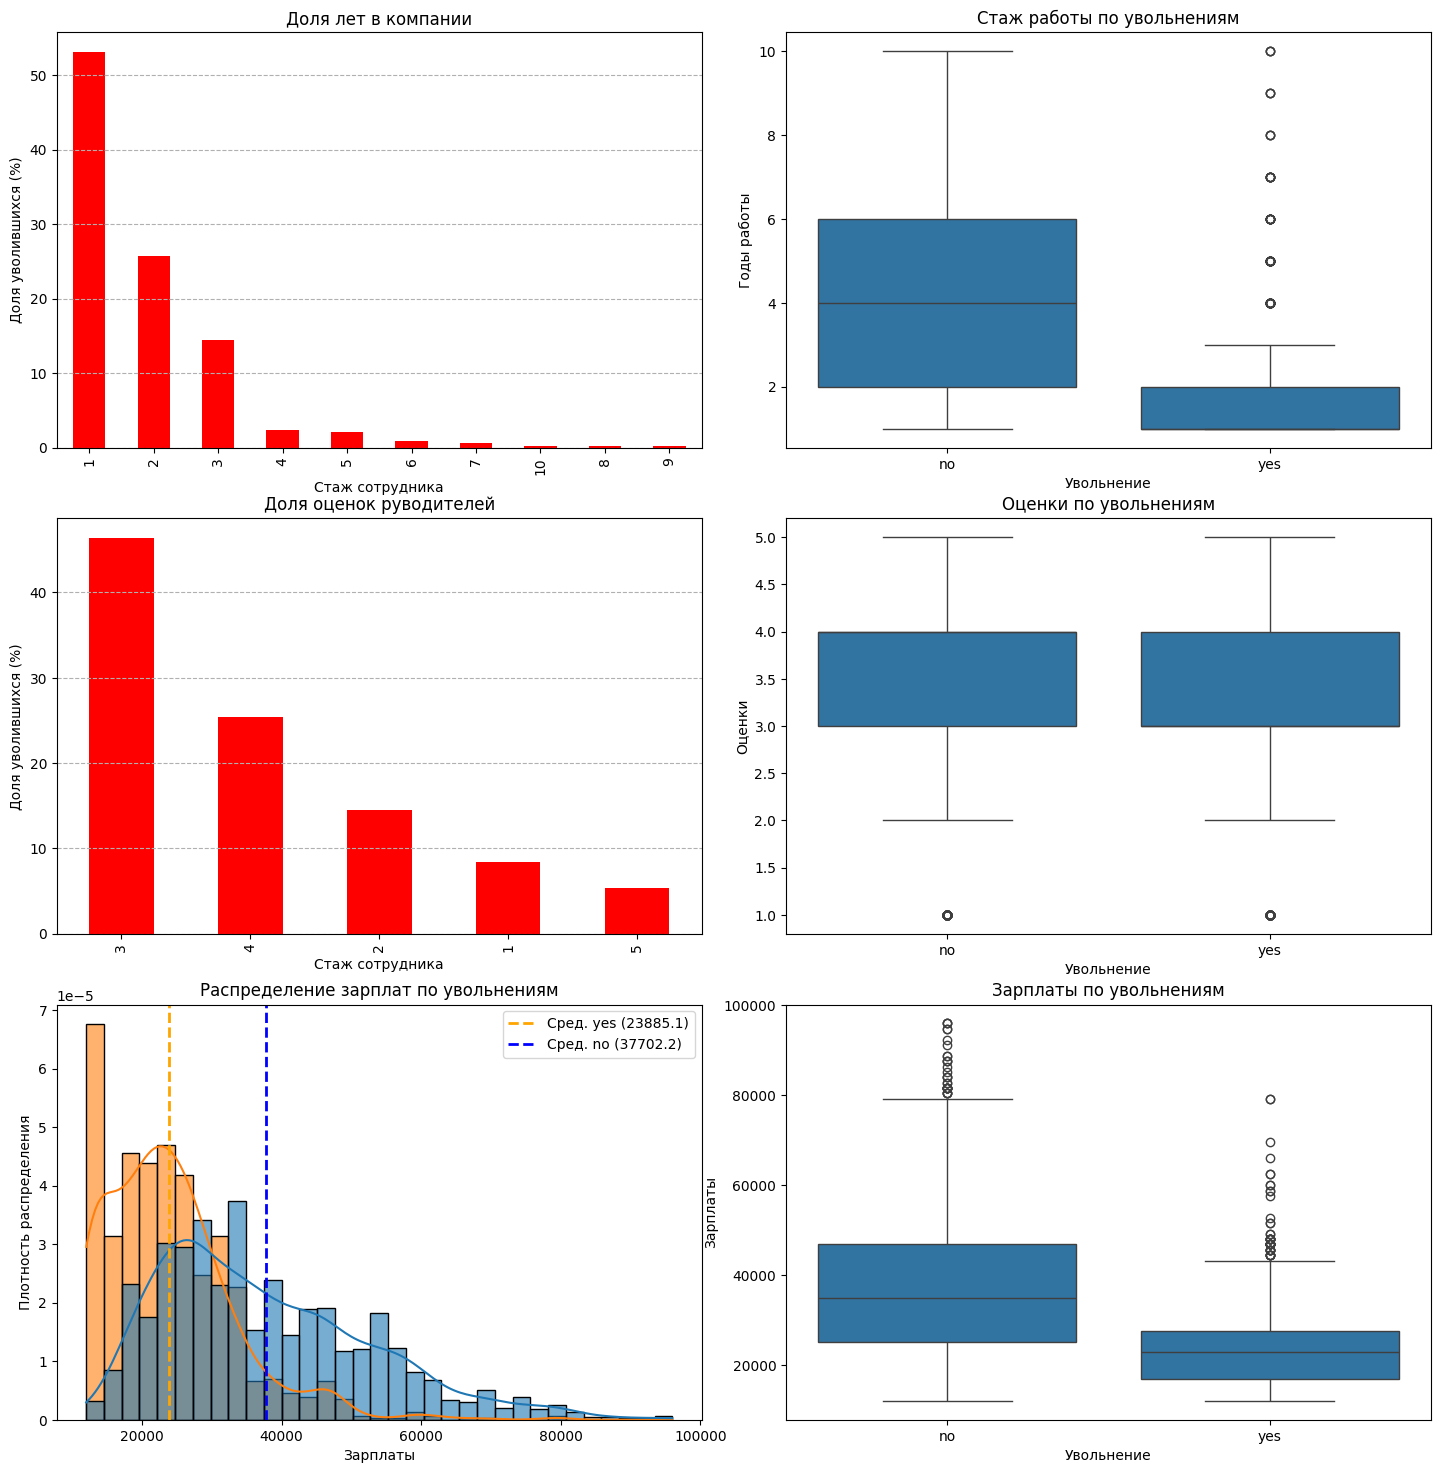

In [59]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

plt.tight_layout(pad=3.0)

year = train_quit.loc[train_quit['quit'] == 'yes', 'employment_years'].value_counts(normalize=True).mul(100)
year.plot(kind='bar', ax=axes[0, 0], color='red')
axes[0, 0].set_title('Доля лет в компании')
axes[0, 0].set_xlabel('Стаж сотрудника')
axes[0, 0].set_ylabel('Доля уволившихся (%)')
axes[0, 0].grid(axis='y', linestyle='--')

sns.boxplot(data=train_quit, x='quit', y='employment_years', ax=axes[0, 1])
axes[0, 1].set_title('Стаж работы по увольнениям')
axes[0, 1].set_xlabel('Увольнение')
axes[0, 1].set_ylabel('Годы работы')

evaluation = train_quit.loc[train_quit['quit'] == 'yes', 'supervisor_evaluation'].value_counts(normalize=True).mul(100)
evaluation.plot(kind='bar', ax=axes[1, 0], color='red')
axes[1, 0].set_title('Доля оценок руводителей')
axes[1, 0].set_xlabel('Стаж сотрудника')
axes[1, 0].set_ylabel('Доля уволившихся (%)')
axes[1, 0].grid(axis='y', linestyle='--')

sns.boxplot(data=train_quit, x='quit', y='supervisor_evaluation', ax=axes[1, 1])
axes[1, 1].set_title('Оценки по увольнениям')
axes[1, 1].set_xlabel('Увольнение')
axes[1, 1].set_ylabel('Оценки')

sns.histplot(data=train_quit, x='salary', hue='quit',
             stat='density', common_norm=False, ax=axes[2, 0],
             kde=True, alpha=0.6)

for status, color in zip(['yes', 'no'], ['orange', 'blue']):
    mean_value = train_quit[train_quit['quit'] == status]['salary'].mean()
    axes[2, 0].axvline(mean_value, color=color, linestyle='--', linewidth=2,
                      label=f'Сред. {status} ({mean_value:.1f})')
axes[2, 0].set_xlabel('Зарплаты')
axes[2, 0].set_ylabel('Плотность распределения')
axes[2, 0].set_title('Распределение зарплат по увольнениям')
axes[2, 0].legend()

sns.boxplot(data=train_quit, x='quit', y='salary', ax=axes[2, 1])
axes[2, 1].set_title('Зарплаты по увольнениям')
axes[2, 1].set_xlabel('Увольнение')
axes[2, 1].set_ylabel('Зарплаты');

**Время работы в компании** По графикам видно, что чаще всего увольняются новые сотрудники, отработавщие от 1 до 3 лет в компании.
<br>
**Оценки сотрудников** Из графиков можно сделать вывод, что чем выше оценка сотрудника, тем меньше вероятность того, что он уволится из компании.
<br>
**Зарплаты сотрудников** Зарплата сотрудников очень сильно влияет на вероятность увольнение, чем меньше зарплата по отношению к средней, тем выше вероятность того, что сотрудник уволится. Разница в средних зарплатах составляет более 10 тысяч

То же самое делаю для тестовой выборки

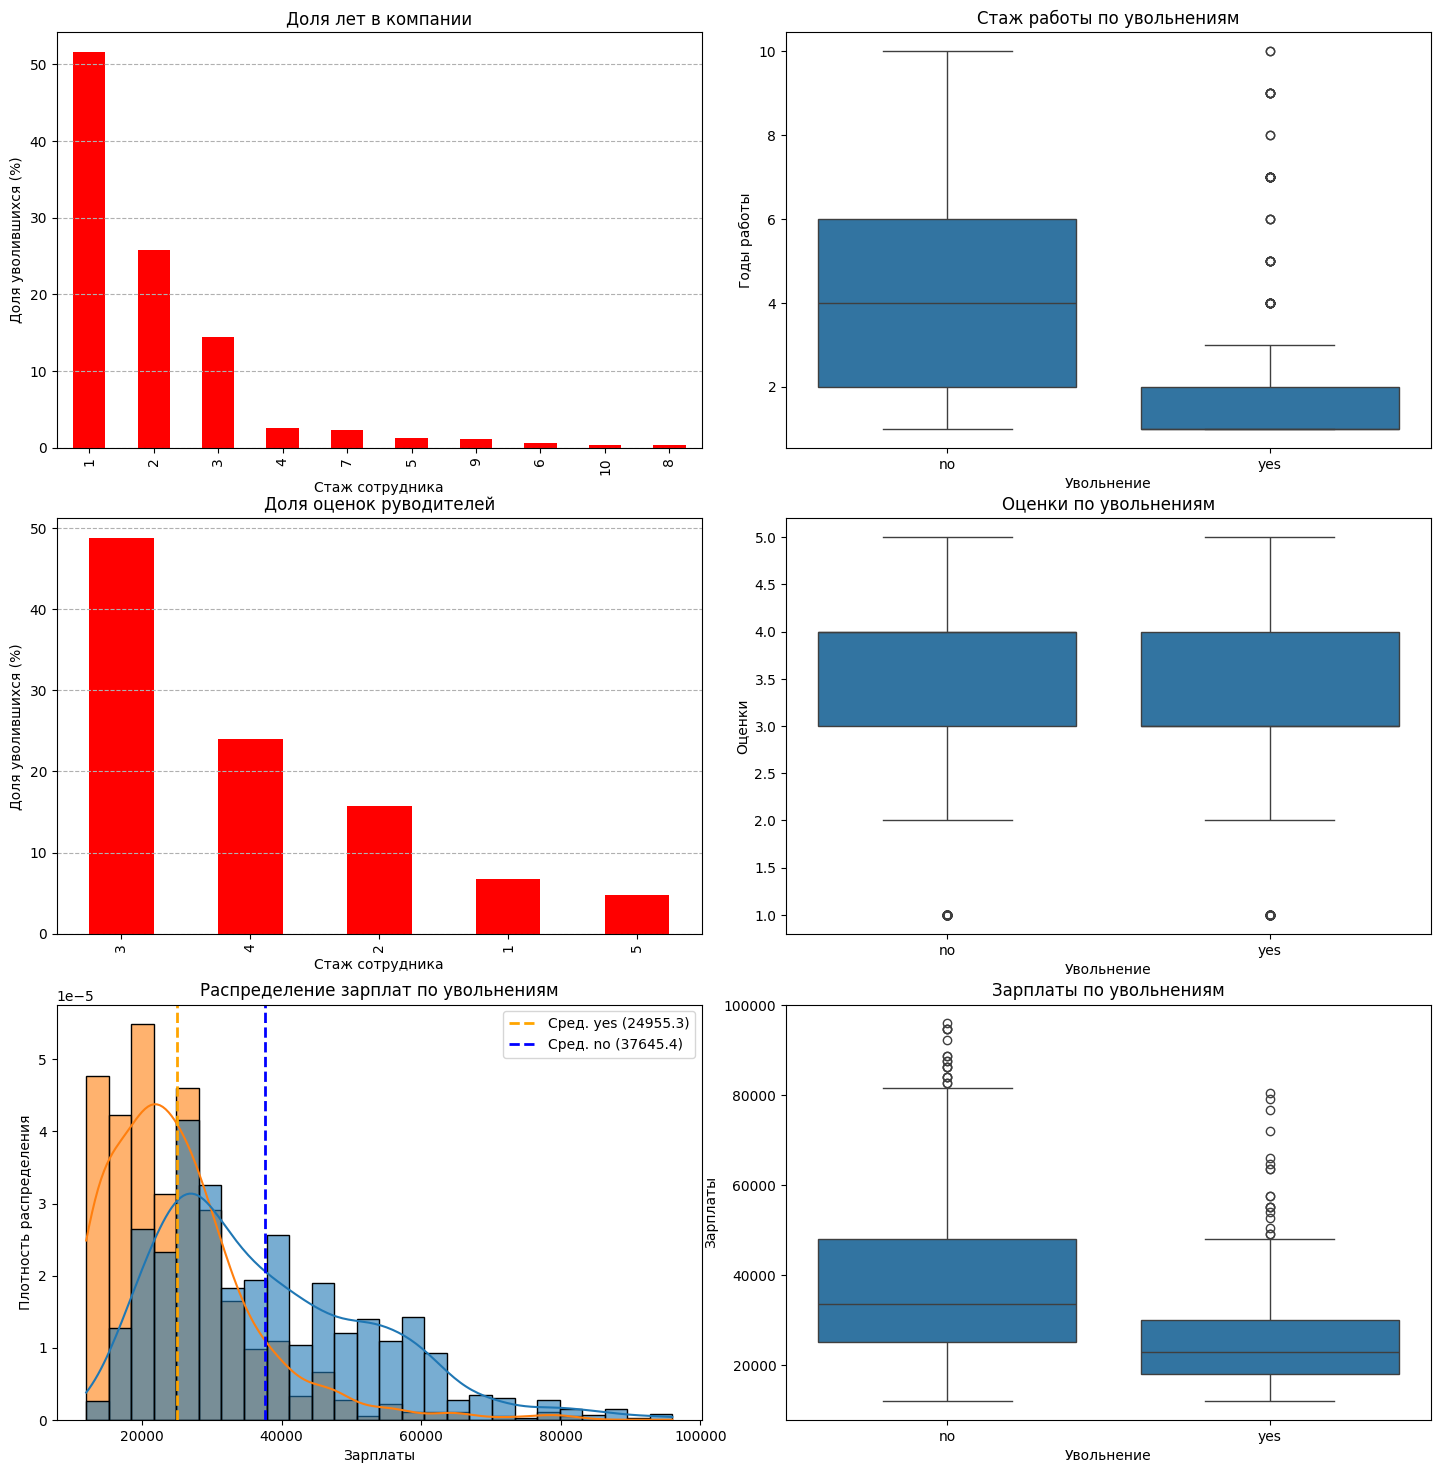

In [60]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

plt.tight_layout(pad=3.0)

year = eda_second.loc[eda_second['quit'] == 'yes', 'employment_years'].value_counts(normalize=True).mul(100)
year.plot(kind='bar', ax=axes[0, 0], color='red')
axes[0, 0].set_title('Доля лет в компании')
axes[0, 0].set_xlabel('Стаж сотрудника')
axes[0, 0].set_ylabel('Доля уволившихся (%)')
axes[0, 0].grid(axis='y', linestyle='--')

sns.boxplot(data=eda_second, x='quit', y='employment_years', ax=axes[0, 1])
axes[0, 1].set_title('Стаж работы по увольнениям')
axes[0, 1].set_xlabel('Увольнение')
axes[0, 1].set_ylabel('Годы работы')

evaluation = eda_second.loc[eda_second['quit'] == 'yes', 'supervisor_evaluation'].value_counts(normalize=True).mul(100)
evaluation.plot(kind='bar', ax=axes[1, 0], color='red')
axes[1, 0].set_title('Доля оценок руводителей')
axes[1, 0].set_xlabel('Стаж сотрудника')
axes[1, 0].set_ylabel('Доля уволившихся (%)')
axes[1, 0].grid(axis='y', linestyle='--')

sns.boxplot(data=eda_second, x='quit', y='supervisor_evaluation', ax=axes[1, 1])
axes[1, 1].set_title('Оценки по увольнениям')
axes[1, 1].set_xlabel('Увольнение')
axes[1, 1].set_ylabel('Оценки')

sns.histplot(data=eda_second, x='salary', hue='quit',
             stat='density', common_norm=False, ax=axes[2, 0],
             kde=True, alpha=0.6)

for status, color in zip(['yes', 'no'], ['orange', 'blue']):
    mean_value = eda_second[eda_second['quit'] == status]['salary'].mean()
    axes[2, 0].axvline(mean_value, color=color, linestyle='--', linewidth=2,
                      label=f'Сред. {status} ({mean_value:.1f})')
axes[2, 0].set_xlabel('Зарплаты')
axes[2, 0].set_ylabel('Плотность распределения')
axes[2, 0].set_title('Распределение зарплат по увольнениям')
axes[2, 0].legend()

sns.boxplot(data=eda_second, x='quit', y='salary', ax=axes[2, 1])
axes[2, 1].set_title('Зарплаты по увольнениям')
axes[2, 1].set_xlabel('Увольнение')
axes[2, 1].set_ylabel('Зарплаты');

На тренировочной выборке видны те же самые доли и зависимости, что и на тестовой

Далее рассматриваю категориальные признаки в данных

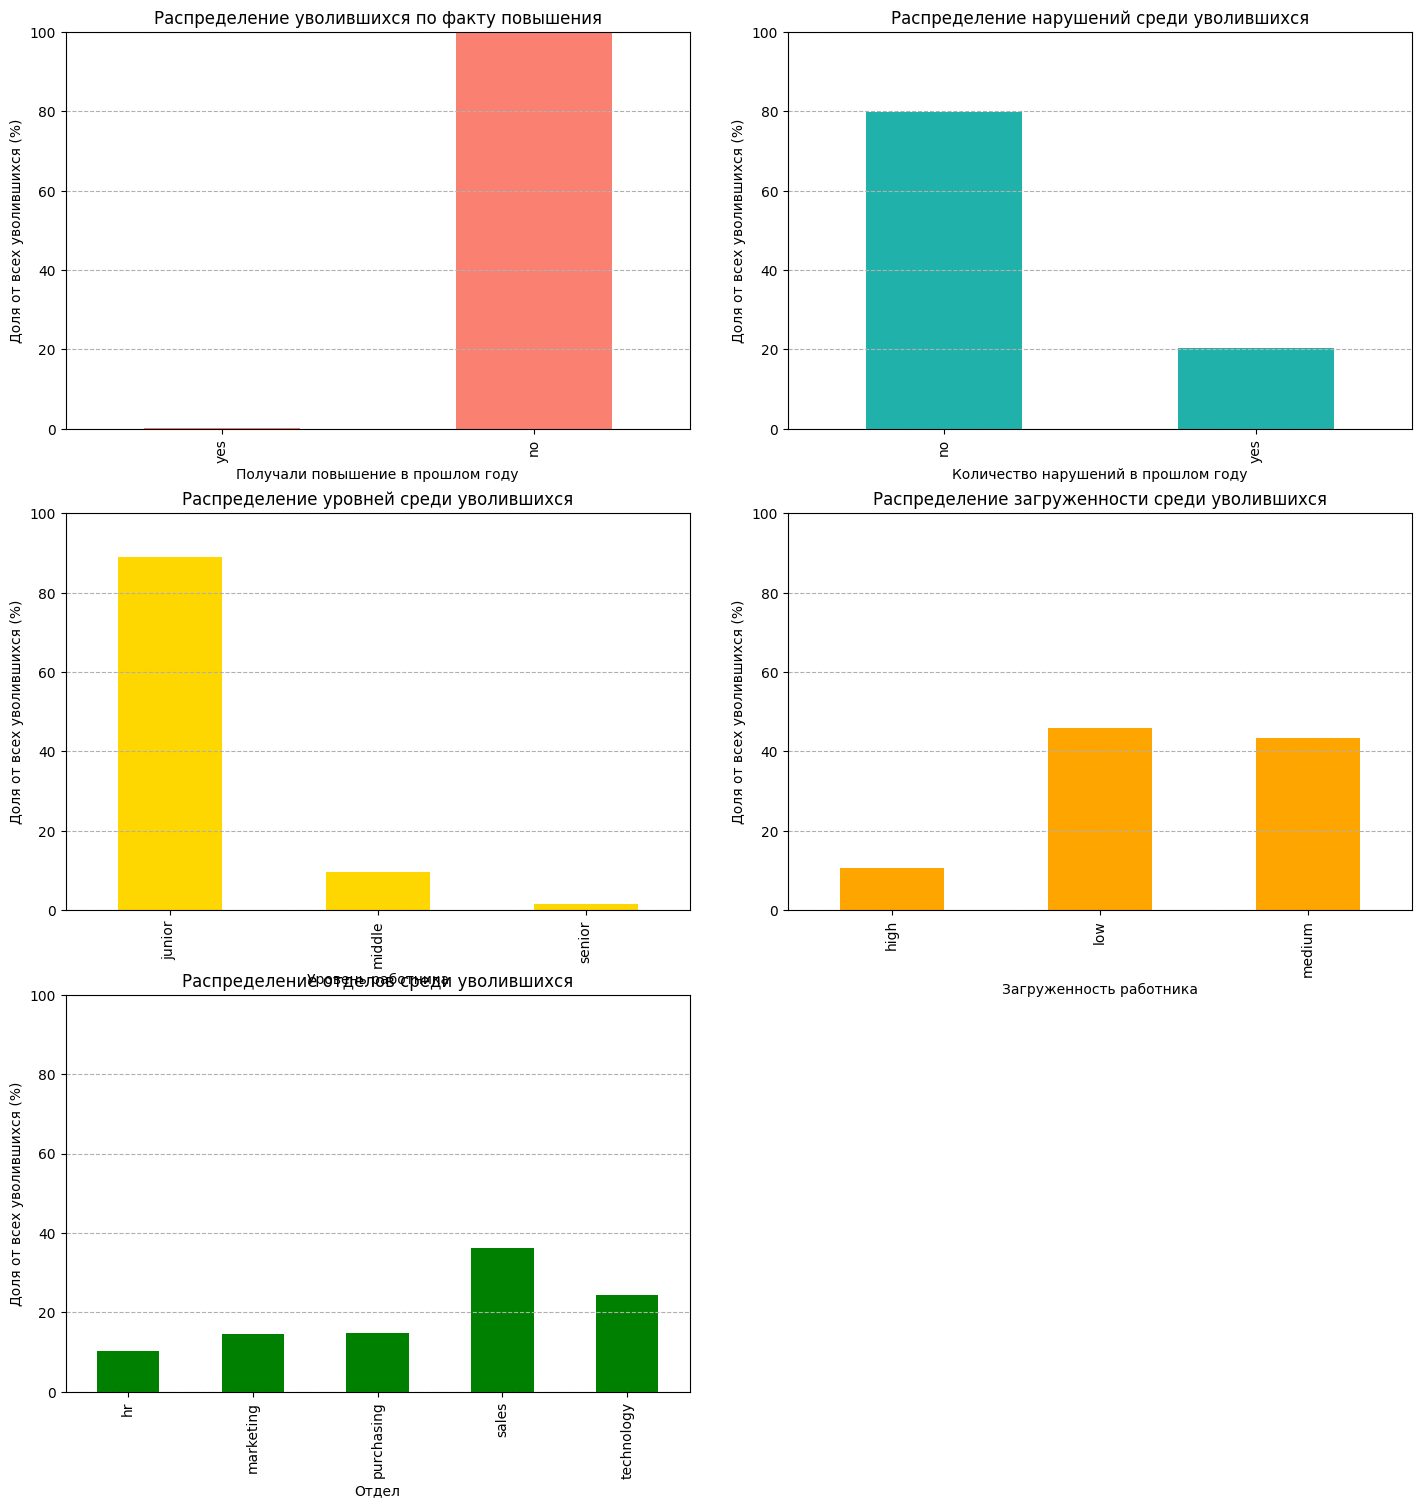

In [61]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
plt.tight_layout(pad=4.0)

axes[2, 1].axis('off')

promo_dist = (
    train_quit[train_quit['quit'] == 'yes']
    .groupby('last_year_promo').size()
    .div(len(train_quit[train_quit['quit'] == 'yes']))
    .mul(100)
    .sort_index(ascending=False)
)
promo_dist.plot(kind='bar',
               ax=axes[0, 0],
               color='salmon',
               title='Распределение уволившихся по факту повышения',
               xlabel='Получали повышение в прошлом году',
               ylabel='Доля от всех уволившихся (%)',
               ylim=(0, 100))

axes[0, 0].grid(axis='y', linestyle='--')

violations_dist = (
    train_quit[train_quit['quit'] == 'yes']['last_year_violations']
    .value_counts(normalize=True)
    .mul(100)
    .sort_index()
)

violations_dist.plot(
    kind='bar',
    ax=axes[0, 1],
    color='lightseagreen',
    title='Распределение нарушений среди уволившихся',
    xlabel='Количество нарушений в прошлом году',
    ylabel='Доля от всех уволившихся (%)',
    ylim=(0, 100)
)
axes[0, 1].grid(axis='y', linestyle='--')

level_dist = (
    train_quit[train_quit['quit'] == 'yes']
    .groupby('level').size()
    .div(len(train_quit[train_quit['quit'] == 'yes']))
    .mul(100)
    .sort_index()
)

level_dist.plot(kind='bar',
               ax=axes[1, 0],
               color='gold',
               title='Распределение уровней среди уволившихся',
               xlabel='Уровень работника',
               ylabel='Доля от всех уволившихся (%)',
               ylim=(0, 100))

axes[1, 0].grid(axis='y', linestyle='--')

workload_dist = (
    train_quit[train_quit['quit'] == 'yes']
    .groupby('workload').size()
    .div(len(train_quit[train_quit['quit'] == 'yes']))
    .mul(100)
    .sort_index()
)

workload_dist.plot(kind='bar',
               ax=axes[1, 1],
               color='orange',
               title='Распределение загруженности среди уволившихся',
               xlabel='Загруженность работника',
               ylabel='Доля от всех уволившихся (%)',
               ylim=(0, 100))

axes[1, 1].grid(axis='y', linestyle='--')

dept_dist = (
    train_quit[train_quit['quit'] == 'yes']
    .groupby('dept').size()
    .div(len(train_quit[train_quit['quit'] == 'yes']))
    .mul(100)
    .sort_index()
)

dept_dist.plot(kind='bar',
               ax=axes[2, 0],
               color='green',
               title='Распределение отделов среди уволившихся',
               xlabel='Отдел',
               ylabel='Доля от всех уволившихся (%)',
               ylim=(0, 100))

axes[2, 0].grid(axis='y', linestyle='--')

**Повышения** Никто из уволившихся сотрудников не получал повышение в прошлом году
<br>
**Нарушения** Доля уволившихся людей с нарушениями составляет 20 процентов от общей доли ушедших из компании
<br>
**Должности** Самая высокая доля увольнений у Junior специалистов
<br>
**Загруженность** Больше половины увольнений приходится на работников с низкой и средней загруженностью на работе
<br>
**Отделы** Чаще всего увольняются с отдела продаж и технологий

Строю те же графики для тестовой выборки

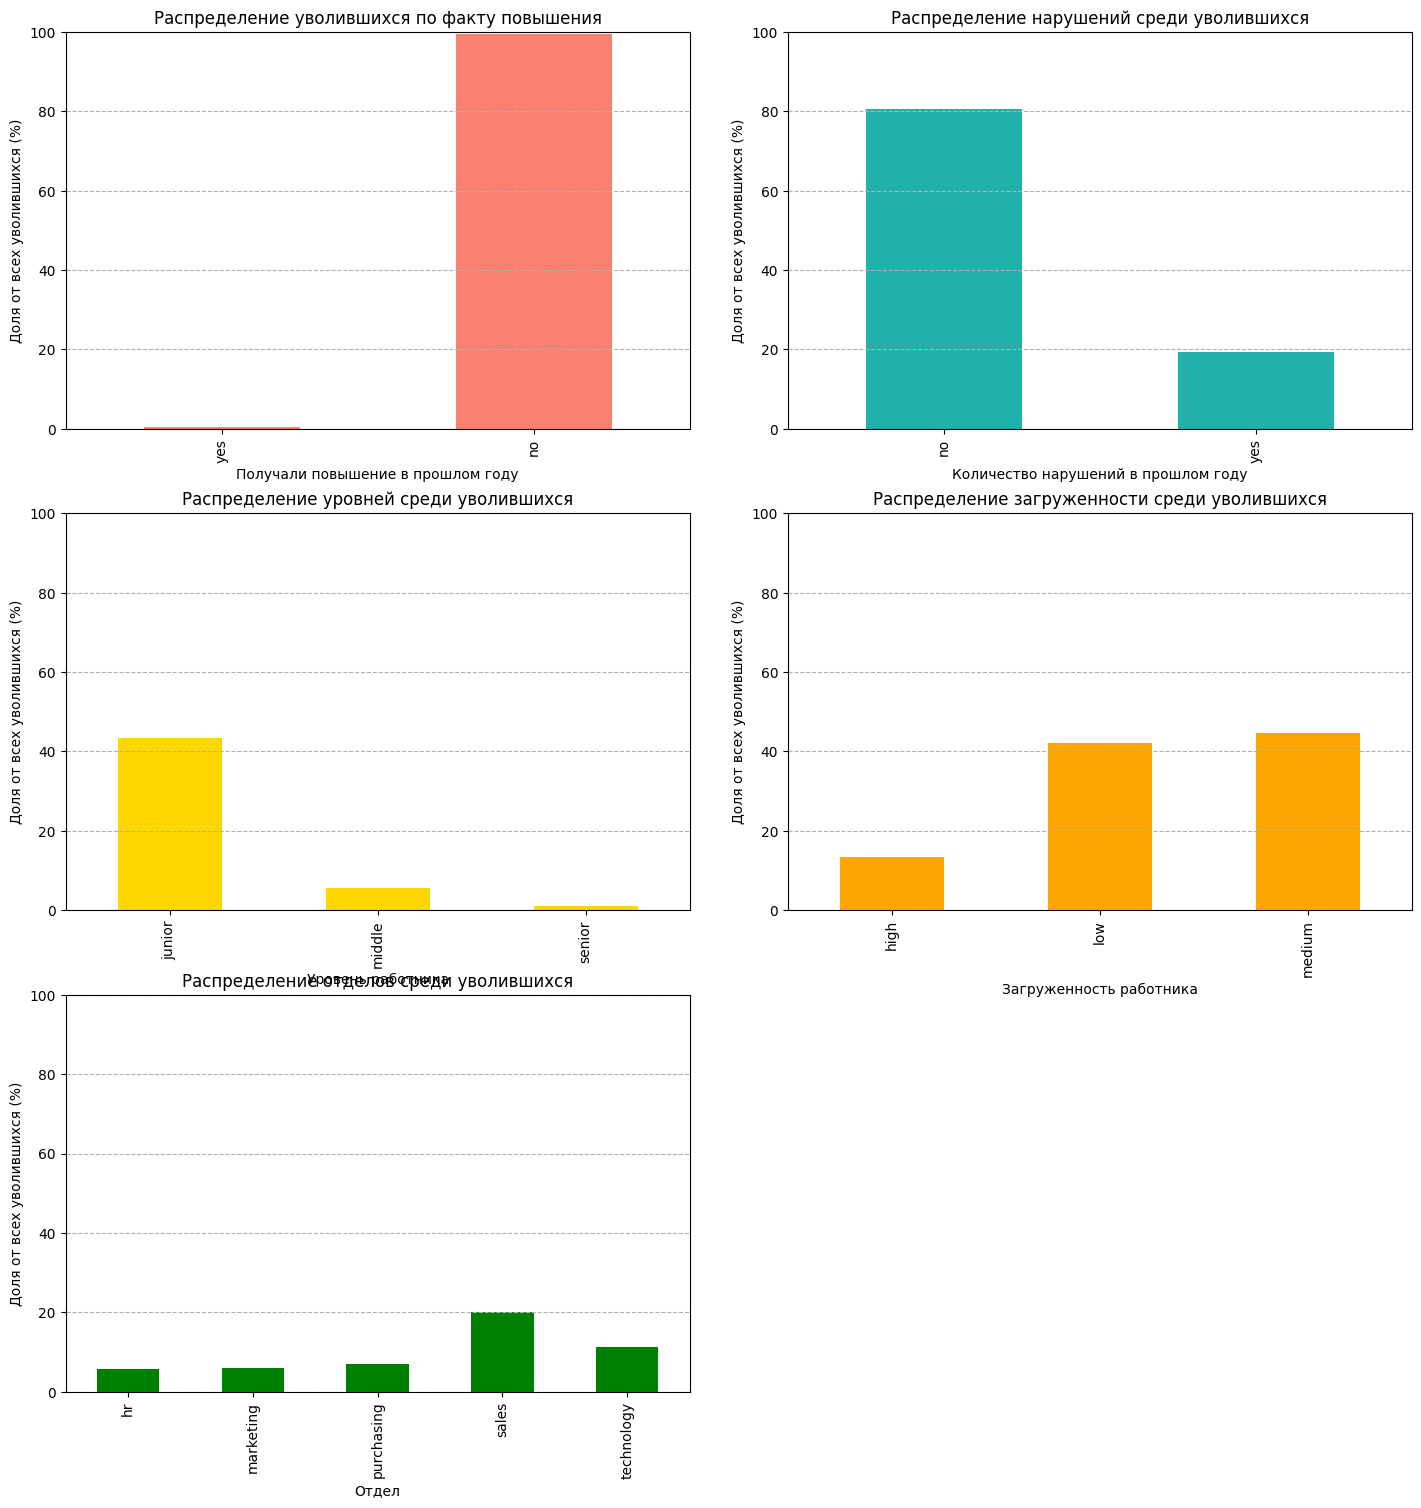

In [62]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
plt.tight_layout(pad=4.0)

axes[2, 1].axis('off')

promo_dist = (
    eda_second[eda_second['quit'] == 'yes']['last_year_promo']
    .value_counts(normalize=True, ascending=False)
    .mul(100)
    .reindex(['yes', 'no'], fill_value=0)
)
promo_dist.plot(kind='bar',
               ax=axes[0, 0],
               color='salmon',
               title='Распределение уволившихся по факту повышения',
               xlabel='Получали повышение в прошлом году',
               ylabel='Доля от всех уволившихся (%)',
               ylim=(0, 100))

axes[0, 0].grid(axis='y', linestyle='--')

violations_dist = (
    eda_second[eda_second['quit'] == 'yes']['last_year_violations']
    .value_counts(normalize=True)
    .mul(100)
    .sort_index()
)

violations_dist.plot(
    kind='bar',
    ax=axes[0, 1],
    color='lightseagreen',
    title='Распределение нарушений среди уволившихся',
    xlabel='Количество нарушений в прошлом году',
    ylabel='Доля от всех уволившихся (%)',
    ylim=(0, 100)
)
axes[0, 1].grid(axis='y', linestyle='--')

level_dist = (
    eda_second[eda_second['quit'] == 'yes']
    .groupby('level').size()
    .div(len(train_quit[train_quit['quit'] == 'yes']))
    .mul(100)
    .sort_index()
)

level_dist.plot(kind='bar',
               ax=axes[1, 0],
               color='gold',
               title='Распределение уровней среди уволившихся',
               xlabel='Уровень работника',
               ylabel='Доля от всех уволившихся (%)',
               ylim=(0, 100))

axes[1, 0].grid(axis='y', linestyle='--')

workload_dist = (
    eda_second[eda_second['quit'] == 'yes']
    .groupby('workload').size()
    .div(len(eda_second[eda_second['quit'] == 'yes']))
    .mul(100)
    .sort_index()
)

workload_dist.plot(kind='bar',
               ax=axes[1, 1],
               color='orange',
               title='Распределение загруженности среди уволившихся',
               xlabel='Загруженность работника',
               ylabel='Доля от всех уволившихся (%)',
               ylim=(0, 100))

axes[1, 1].grid(axis='y', linestyle='--')

dept_dist = (
    eda_second[eda_second['quit'] == 'yes']
    .groupby('dept').size()
    .div(len(train_quit[train_quit['quit'] == 'yes']))
    .mul(100)
    .sort_index()
)

dept_dist.plot(kind='bar',
               ax=axes[2, 0],
               color='green',
               title='Распределение отделов среди уволившихся',
               xlabel='Отдел',
               ylabel='Доля от всех уволившихся (%)',
               ylim=(0, 100))

axes[2, 0].grid(axis='y', linestyle='--')

В тестовой выборке видны примерно те же соотношения, что и в тренировочной

Рассматриваю оставшиеся признаки с помощью графика sunburst

In [63]:
for_plot = train_quit.copy()
for_plot["value"] = 1

In [64]:
df_agg = for_plot.groupby([
    "quit",
    "dept",
    "workload"
]).size().reset_index(name="value")

In [65]:
fig = px.sunburst(
    df_agg,
    path=[
        "quit",
        "dept",
        "workload",
    ],
    values="value",
    title="Иерархия увольнений",
    width=800,
    height=800,
    color="quit",
    color_discrete_sequence=px.colors.qualitative.Pastel
)

fig.update_traces(textinfo="label+percent parent")
fig.show()

Чаще всего увольняются люди из отдела продаж и отдела технологий, что интересно, среди этих сотрудников почти половина людей имеет низкую загруженность по работе. Из них реже всего увольняются люди с высокой загруженностью.

### 3.3 Портрет «уволившегося сотрудника»

Сотрудники наиболее сколнные к увольнению работают в компании от 1 до 3 лет, руководители оценивают их, как правило, от 1 до 3 баллов. Их средняя зарпалата около 20 тысяч и ниже. У них не было повышений за последний год. Если были нарушения, то это повышает вероятность того, что сотрудник уволится. Скорее всего он работает на должности junior специалиста в отделе продаж или технологий и имеет низкую или среднюю загруженность по работе.

### 3.4 Удовлетворенность работой

Создаю датафрейм для анализа отношения удовлетворенности работой к увольнениям

In [66]:
quit_by_satisfaction = pd.merge(target_df, target_quit, left_index=True, right_index=True)
quit_by_satisfaction.head(5)

,job_satisfaction_rate,quit
id,,
130604,0.74,no
825977,0.75,no
418490,0.60,yes
555320,0.72,no
826430,0.08,yes


Строю график, чтобы визуализировать отношение

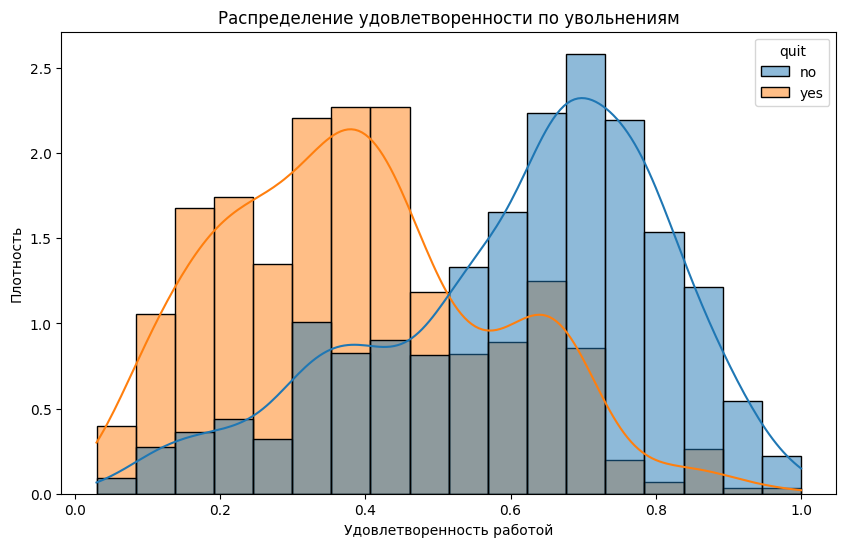

In [68]:
plt.figure(figsize=(10, 6))
sns.histplot(data=quit_by_satisfaction, x='job_satisfaction_rate',
             hue='quit', stat='density', common_norm=False, kde=True)
plt.title('Распределение удовлетворенности по увольнениям')
plt.xlabel('Удовлетворенность работой')
plt.ylabel('Плотность')
plt.show()

Удовлетворенность работой действительно влияет на то, что сотрудник уволиться из компании. Чем выше удовлетворенность, тем ниже вероятность увольнения.

## 4 Добавление нового признака

Делаю предсказания, с помощью лучшей модели для тренировочной и тестовой выборок и создаю столбцы с новым признаком

In [69]:
train_quit['job_satisfaction_rate'] = best_pipeline.predict(train_quit)

In [70]:
train_quit.head(5)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.625766
814010,sales,junior,medium,2,no,no,4,27600,no,0.844603
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.402012
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.318232
910140,marketing,junior,medium,2,no,no,5,25200,no,0.774239


In [71]:
test_df['job_satisfaction_rate'] =  best_pipeline.predict(test_df)

In [72]:
test_df.head(5)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.843579
686555,hr,junior,medium,1,no,no,4,30000,0.671975
467458,sales,middle,low,5,no,no,4,19200,0.672141
418655,sales,middle,low,6,no,no,4,19200,0.668869
789145,hr,middle,medium,5,no,no,5,40800,0.789752


### 4.1 Корреляционный анализ

Строю матрицы корреляций для тренировочной и тестовой выборок

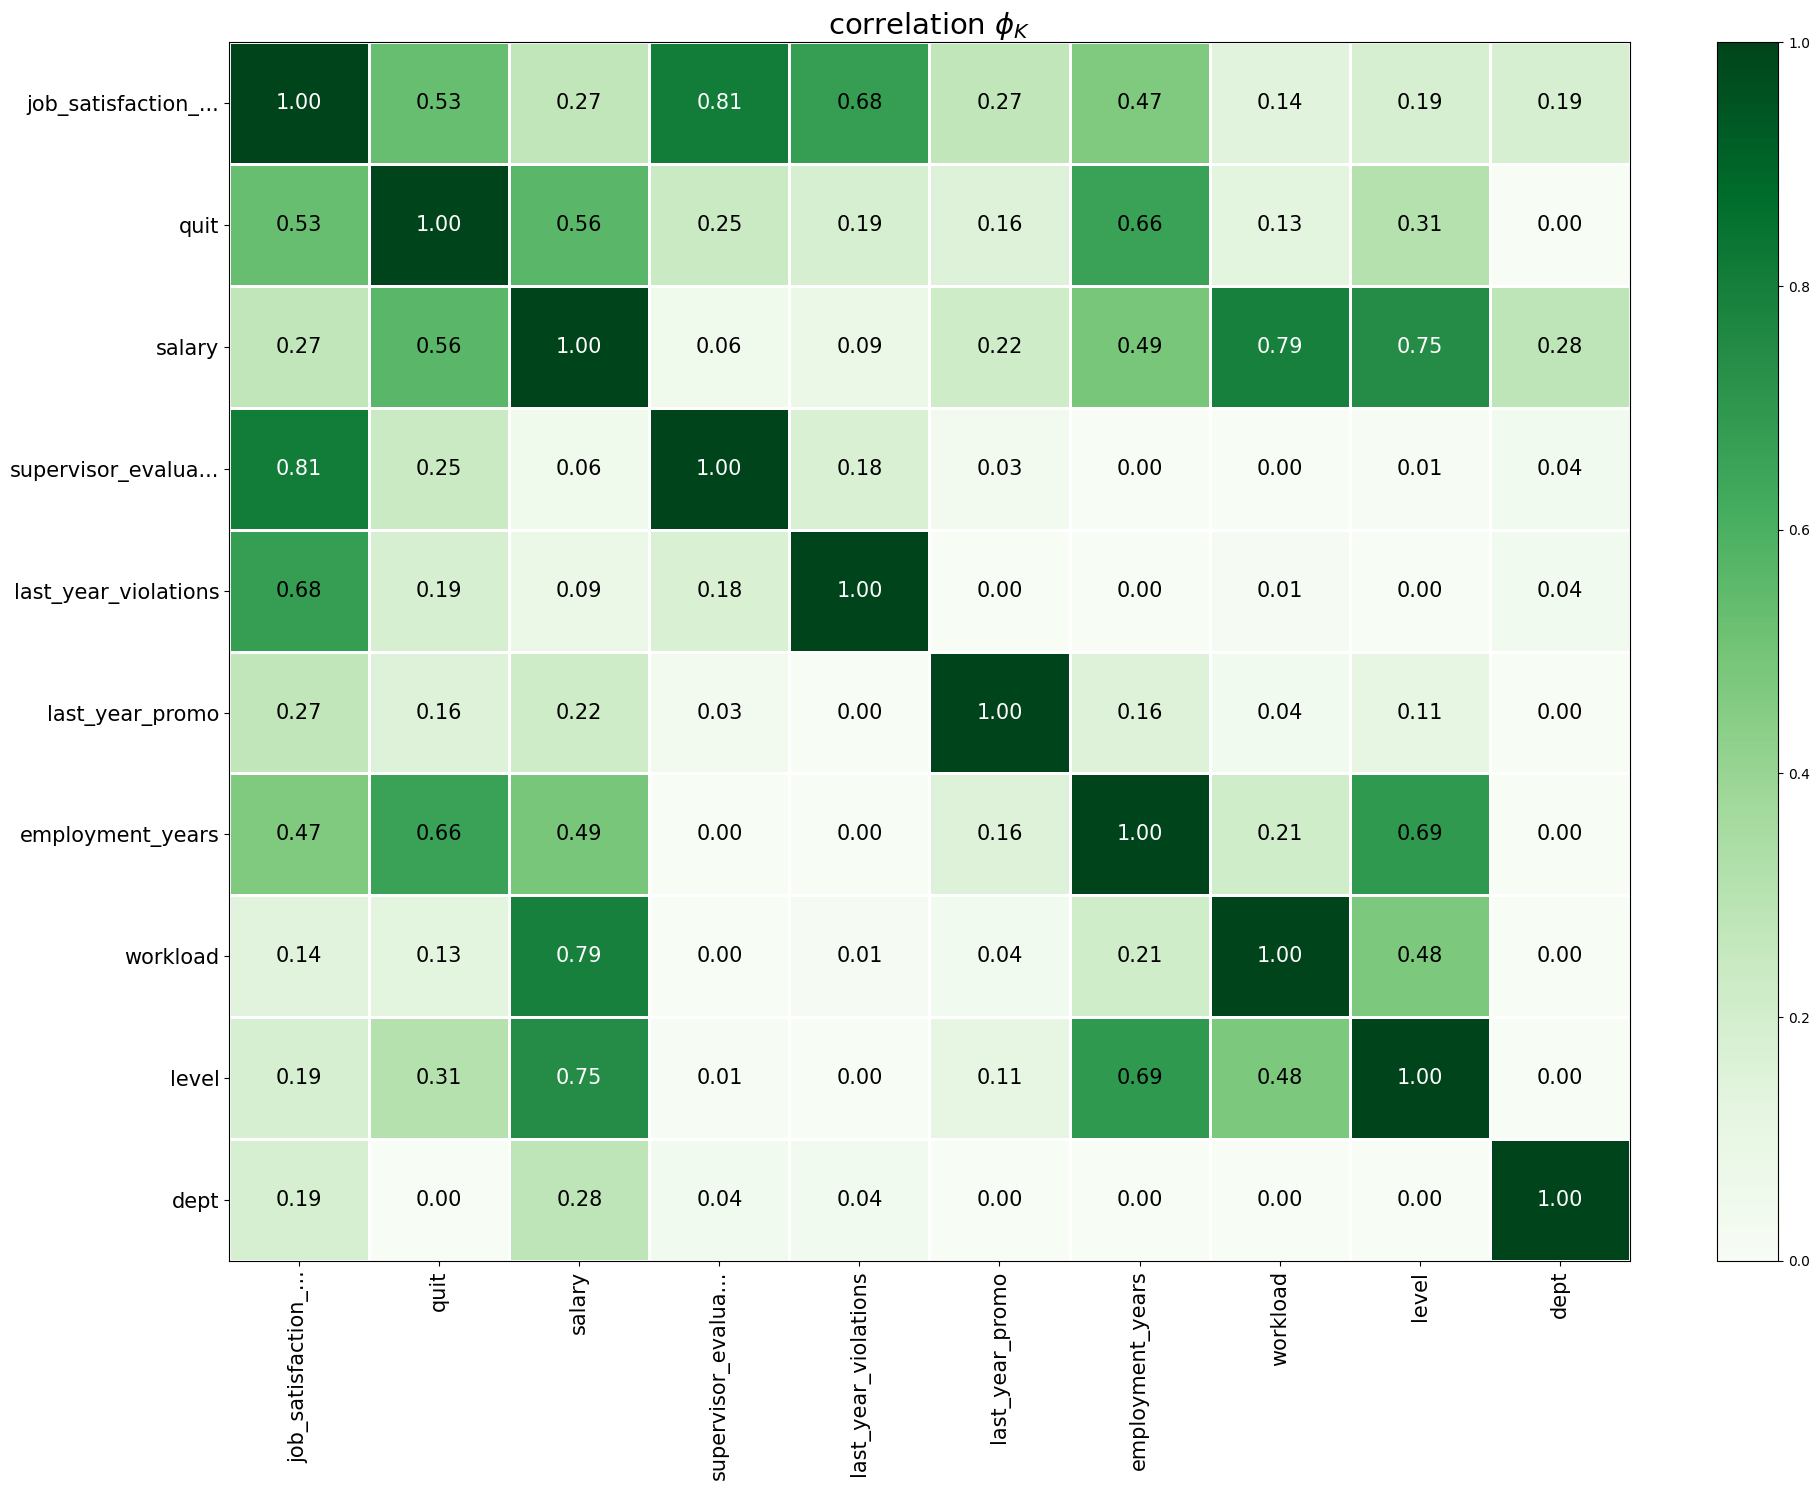

In [73]:
interval_cols = ['salary', 'job_satisfaction_rate']

phik_overview = phik_matrix(train_quit, interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

У целевого признака наблюдается корреляция с зарплатой, стажем работы, занимаемой должностью и удовлетворенностью работой. По матрице нет взаимосвзяи с отделом. Мультиколлинеарности в признаках не обнаружено.

In [74]:
corr_data = pd.merge(test_df, target_quit, right_index=True, left_index=True)

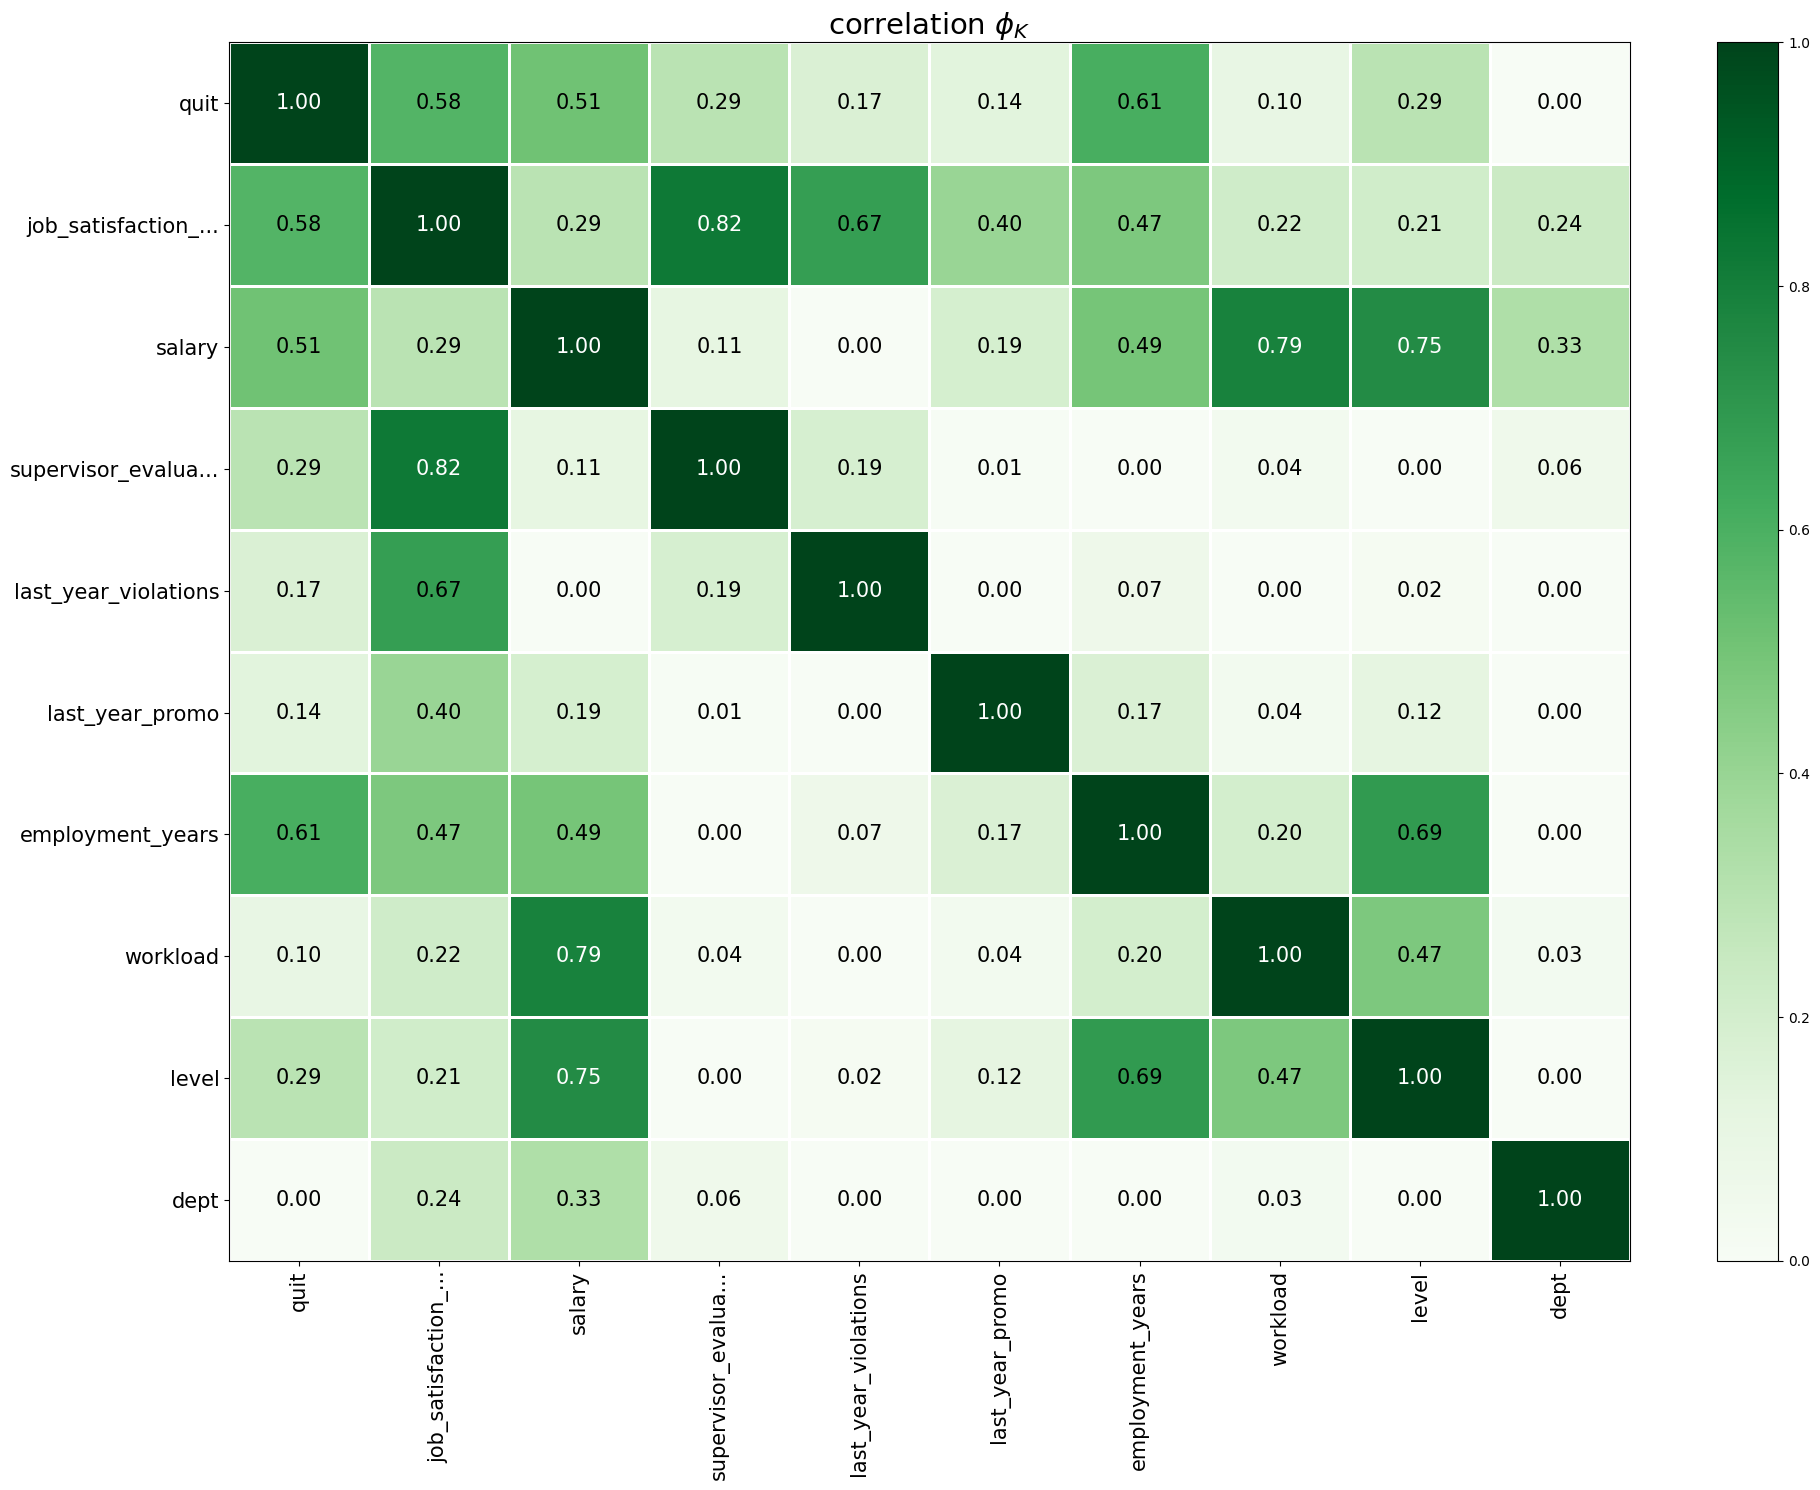

In [75]:
interval_cols = ['employment_years', 'salary', 'job_satisfaction_rate']

phik_overview = phik_matrix(corr_data, interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Матрица на тестовой выборке в целом показывает ту же картину

## 5 Подготовка данных

Убираю дубликаты из тестовой выбороки, чтобы не было переобучения

In [76]:
train_quit = train_quit.drop_duplicates()
print(train_quit.duplicated().sum())

0


Объединяю тестовые данные по индексу(Id), чтобы сравнивать предсказания с реальными значениями для одного и того же работника

In [77]:
new_test_data = pd.merge(test_df, target_quit, left_index=True, right_index=True)
new_test_data.head(5)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.843579,no
686555,hr,junior,medium,1,no,no,4,30000,0.671975,no
467458,sales,middle,low,5,no,no,4,19200,0.672141,no
418655,sales,middle,low,6,no,no,4,19200,0.668869,no
789145,hr,middle,medium,5,no,no,5,40800,0.789752,no


Удаляю признаки с низкой корреляцией, чтобы повысить качество модели

In [78]:
train_drop = train_quit.drop('dept', axis=1)

In [79]:
test_drop = new_test_data.drop('dept', axis=1)

Назначаю новые переменные для обучения модели

In [80]:
X_train_new = train_drop.drop('quit', axis=1)
y_train_new = train_drop['quit']

X_test_new = test_drop.drop('quit', axis=1)
y_test_new = test_drop['quit']

label_encoder = LabelEncoder()
y_encoded_train = label_encoder.fit_transform(y_train_new)
y_encoded_test = label_encoder.transform(y_test_new)

In [81]:
ohe_columns = ['level', 'last_year_promo','last_year_violations']
ord_columns = ['workload']
num_columns = ['employment_years', 'salary', 'job_satisfaction_rate', 'supervisor_evaluation']

Создаю кодировщик и итоговый пайплайн для обучения

In [82]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
         ('ord',  OrdinalEncoder(
                categories=[
                    ['high', 'medium', 'low'],
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [83]:
data_preprocessor_new = ColumnTransformer(
    [
     ('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', RobustScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [84]:
pipe_final_new = Pipeline([
    ('preprocessor', data_preprocessor_new),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

## 6 Обучение модели

Создаю словарь с несколькими моделями

In [85]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': [5, 10, None],
        'models__max_features': range(2, 15),
        'models__min_samples_split': [10, 20, 30],
        'models__min_samples_leaf': [1, 2, 4],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },

    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': list(range(3, 20, 2)),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },

     {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='saga',
            penalty='l2'
        )],
        'models__C': np.logspace(-4, 4, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }

]

С помощью рандомного поиска ищу лучшую модель и лучшие гиперпараметры для нее

In [86]:
randomized_search = RandomizedSearchCV(
    pipe_final_new,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)
randomized_search.fit(X_train_new, y_encoded_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['leve...
                                         'models__C': array([1.00000000e-04, 3.72759372e-04, 1.38949549e-03, 5.17947468e-03,
       1.93069773e-02, 7.19685673e-02, 2.68269580e-01, 1.00000000e+00,
       3.72759372e+00, 1.38949549e+01, 5.17947468e+01, 1.93069773e+02,
       7.19685673e+02, 2.68269580e+03, 1.00000000e+04]),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc', verbose=1)

In [87]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидационной:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['level', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                           

In [88]:
best_model = randomized_search.best_estimator_
y_pred_new = best_model.predict_proba(X_test_new)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_encoded_test, y_pred_new)}')

Метрика ROC-AUC на тестовой выборке: 0.9186465309468776


Лучшая модель - дерево решений с метрикой roc-auc 0.92

Проверяю адекватность модели с помощью DummyClassifier

In [90]:
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy_clf.fit(X_train_new, y_encoded_train)

y_pred_dummy = dummy_clf.predict_proba(X_test_new)[:, 1]
print('Метрика фиктивной модели:', roc_auc_score(y_encoded_test, y_pred_dummy))

Метрика фиктивной модели: 0.5


Метрика DummyClassifier вышла хуже, что подтверждает эффективность выбранной модели

## 7 Выводы по 2 задаче

С этой задачей лучше всего справилась модель DecisionTreeClassifier, потому что хорошо обрабатывает нелинейные зависимости, менее чувствителен к выбросам, чем KNN, и автоматически выбирает наиболее значимые признаки

# Общий вывод

Задачей данного проекта было построить модели, предсказывающие поведение сотрудников и их удовлетворенность рабочим местом.
<br>
Этапы работы:
<br>
1. Загрузка и знакомство с данными
2. Предобработка данных
3. Исследовательский анализ, в ходе которого уже делаются первые выводы и предположения о сотрудниках
4. Подготовка данных к обучению
5. Обучение моделей, подбор гиперпараметров и работа с признаками
6. Оформление выводов

В ходе работы был составлен портрет сотрудника, наиболее склонного к увольнению, что может помочь бизнесу сразу находить таких работников и предпринимать меры по их удержанию.
<br>
Чаще всего увольняются работники с зарплатой ниже 20 тысяч, работающие в отделе продаж или отделе технологий, у них чаще всего низкая загруженность по работе.
<br>
Возможные рекомендации:
1. Повышение зарплат сотрудников, если это того стоит и вообще возможно сделать для компании
2. Давать сотрудникам больше интересных задач и проектов, чтобы они не проводили зря рабочее время, был интерес остаться в компании
3. Расширить возможности для роста junior-специалистов, т.к. повышения в компании крайне редки, а отток новых работников очень высокий